In [1]:
## sleep stage classification - 2 class - using SAX features

## feature set variables: window size (0.5, 0.2, 0.1, 0.05), alphabet size (3, 4, 5), word size (dimer, trimer)

## do 10-fold CV
## inside cross-validation, split into train, validation & test indices
## do calc on train & val to get optimal params
#     try :
#     balance with smote / balanced class weight in SVM
#     grid search + CV  -> show plots on train & val error
#     optimise prob thres

## with the optimal params, re-train using train & val, then predict on test set
## merge test set predictions from all folds into a single set - obtain esnsitivity, specificity & conf mat on this set

import pandas as pd
import numpy as np
import os
import pickle
from scipy import stats
#import itertools
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.preprocessing import StandardScaler #, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split

import itertools
from sklearn.svm import SVC
from sklearn.metrics import auc,accuracy_score
from sklearn.metrics import precision_recall_fscore_support,confusion_matrix
from sklearn.metrics import classification_report

In [2]:
###################function to plot confusion matrix#####################################
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
###########################################################################################

In [3]:
## create train & test sets by ID
def CreateTrainTestID(dfull):
    
    ## select IDs
    ID = dfull['pID'].unique() # create ID list
    #np.random.seed(456)   ## select the IDs for the 2 sets
    
    '''
    msk = np.random.rand(len(ID)) < 0.8
    #print('msk')
    #print(msk)
    trainIDs = pd.DataFrame()
    testIDs = pd.DataFrame()
    trainIDs['pID'] = ID[msk]
    testIDs['pID'] = ID[~msk]
    #print(ID[msk])
    #print(ID[~msk])
    print(trainIDs['pID'].tolist())
    print(testIDs['pID'].tolist())
    Train = dfull.loc[dfull['pID'].isin(ID[msk])] # create the train-test sets
    Test = dfull.loc[dfull['pID'].isin(ID[~msk])] #'''
    
    index_list = list(range(len(ID)))
    #print('index list')
    #print(index_list)
    train_index = np.random.choice(np.array(index_list), size = round(0.8*(len(index_list))), replace=False)
    test_index = [i for i in index_list if i not in train_index]
    Train = dfull.loc[dfull['pID'].isin(ID[train_index])]
    Test = dfull.loc[dfull['pID'].isin(ID[test_index])]
    #print('train')
    print(train_index)
    #print('test')
    print(test_index)
        
    return Train, Test

def createXYsets(Train,Test):    
    ## create the sets
    X_train1 = Train.drop(['pID','day','epoch','class_label','class2'], 1).reset_index() #inplace=True, drop=True)  ## create X & y splits
    X_train1 = X_train1.drop(['index'], 1)
    X_test = Test.drop(['pID','day','epoch','class_label','class2'], 1).reset_index() #inplace=True, drop=True)
    X_test = X_test.drop(['index'],1)
    y_train1 = Train['class2'].reset_index() #inplace=True, drop=True)
    y_train1 = y_train1.drop(['index'],1)
    y_test = Test['class2'].reset_index() #inplace=True, drop=True)
    y_test = y_test.drop(['index'],1)
    print(X_train1.head(1))
    return X_train1, y_train1, X_test, y_test

In [28]:
#for i in range(10):
#    print('')    
#    print("Iteration: " + str(i))
#    
#    Train, Test = CreateTrainTestID(dfull)
    #X_train1, y_train1, X_test, y_test = createXYsets(Train,Test)
#    print('')

In [3]:
### load data ###

file_location='C:/Users/DAR9KOR/Desktop/data/HEALTHCARE/EEG/data/eeg_epochs_dec12_2018/raw_data' #C:\\Users\\DAR9KOR\\Desktop\\data\\HEALTHCARE\\EEG\\data\\eeg_epochs_dec12_2018'
os.chdir('C:/Users/DAR9KOR/Desktop/data/HEALTHCARE/EEG/data/eeg_epochs_dec12_2018/raw_data') #'/home/intern_eyecare/Desktop/EEG/raw_data') #C:\\Users\\DAR9KOR\\Desktop\\data\\HEALTHCARE\\EEG\\data\\eeg_epochs_dec12_2018')

# remove 2nd night of subject 13, as there was data loss - pkl file created accordingly
dfull = pickle.load(open('Frac_sax_dimer_0.1s_rm_1st_wake.pkl', 'rb'))
dfull.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,pID,day,epoch,class_label
0,0.093960,0.043624,0.026846,0.003356,0.046980,0.117450,0.107383,0.026846,0.026846,0.104027,0.134228,0.070470,0.003356,0.033557,0.067114,0.093960,400,1,s2e1,wake
1,0.080537,0.023490,0.000000,0.000000,0.020134,0.288591,0.097315,0.003356,0.003356,0.093960,0.218121,0.030201,0.000000,0.000000,0.033557,0.107383,400,1,s3e1,wake
2,0.120805,0.023490,0.000000,0.000000,0.020134,0.244966,0.083893,0.000000,0.003356,0.077181,0.278523,0.016779,0.000000,0.000000,0.016779,0.114094,400,1,s4e1,wake
3,0.163880,0.053512,0.023411,0.003344,0.066890,0.163880,0.033445,0.016722,0.013378,0.053512,0.096990,0.066890,0.000000,0.010033,0.076923,0.157191,400,1,s5e1,wake
4,0.120401,0.036789,0.033445,0.020067,0.053512,0.140468,0.036789,0.013378,0.036789,0.063545,0.197324,0.040134,0.000000,0.006689,0.066890,0.133779,400,1,s5e2,wake


In [ ]:
### check the data ###

In [5]:
# 1. look for null values
dfull.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58169 entries, 0 to 58168
Data columns (total 20 columns):
0              58169 non-null float64
1              58169 non-null float64
2              58169 non-null float64
3              58169 non-null float64
4              58169 non-null float64
5              58169 non-null float64
6              58169 non-null float64
7              58169 non-null float64
8              58169 non-null float64
9              58169 non-null float64
10             58169 non-null float64
11             58169 non-null float64
12             58169 non-null float64
13             58169 non-null float64
14             58169 non-null float64
15             58169 non-null float64
pID            58169 non-null object
day            58169 non-null object
epoch          58169 non-null object
class_label    58169 non-null object
dtypes: float64(16), object(4)
memory usage: 8.9+ MB


In [6]:
dfull.isnull().sum()

0              0
1              0
2              0
3              0
4              0
5              0
6              0
7              0
8              0
9              0
10             0
11             0
12             0
13             0
14             0
15             0
pID            0
day            0
epoch          0
class_label    0
dtype: int64

In [7]:
# 2. check data distribution
dfull.groupby('class_label').size()

class_label
sleep_stage_1     2804
sleep_stage_2    17799
wake             37566
dtype: int64

In [8]:
dfull.groupby(['pID','class_label']).size()

pID  class_label  
400  sleep_stage_1     117
     sleep_stage_2     623
     wake             1992
401  sleep_stage_1     201
     sleep_stage_2    1222
     wake             2319
402  sleep_stage_1     278
     sleep_stage_2     947
     wake             2292
403  sleep_stage_1     106
     sleep_stage_2     885
     wake             2173
404  sleep_stage_1     303
     sleep_stage_2    1134
     wake             1421
405  sleep_stage_1     158
     sleep_stage_2     833
     wake             1668
406  sleep_stage_1     146
     sleep_stage_2     824
     wake             2294
407  sleep_stage_1     173
     sleep_stage_2     795
     wake             2289
408  sleep_stage_1     107
     sleep_stage_2     591
     wake             2061
409  sleep_stage_1     100
     sleep_stage_2    1073
     wake             1116
410  sleep_stage_1     182
     sleep_stage_2    1278
     wake             2037
411  sleep_stage_1      31
     sleep_stage_2     898
     wake             1813
412  slee

In [8]:
dn = dfull[(dfull.day == '2')]
dn.groupby('class_label').size()

class_label
sleep_stage_1     1564
sleep_stage_2     8599
wake             18205
dtype: int64

In [9]:
dn = dfull[(dfull.day == '1')]
dn.groupby('class_label').size()

class_label
sleep_stage_1     1240
sleep_stage_2     9200
wake             19361
dtype: int64

In [4]:
### convert from 3-class to 2-class ###
dfull['class2'] = dfull['class_label']
dfull['class2'] = [0 if x == 'wake' else 1 for x in dfull['class2']]

## convert selected columns to string/categories 
## DO NOT CONVERT 'class2' from numeric to category - this probably gives error in grid search
dfull[['class_label']] = dfull[['class_label']].astype('str')        # ,'class2'

In [14]:
'''## do multiple iterations
sensitivity = []
specificity = []
accuracy = []
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

for i in range(10):
    print('')    
    print("Iteration: " + str(i))
    
    Train, Test = CreateTrainTestID(dfull)
    X_train1, y_train1, X_test, y_test = createXYsets(Train,Test)
    print('')
    
    ### data scaling ###
    scaler = StandardScaler().fit(X_train1)  # StandardScaler();  MinMaxScaler()
    X_train_scaled = scaler.transform(X_train1)    # fit_transform(X_train1)
    X_test_scaled = scaler.transform(X_test)
    
    ## model fitting
    model_svc = SVC(class_weight='balanced')  # probability=True
    model_svc.fit(X_train_scaled, y_train1)
    
    
    ## predict on test data - check metrics
    y_pred = model_svc.predict(X_test_scaled)
    
    
    #####    Compute confusion matrix     ####
    class_names = ['0','1'] #['wake','sleep_stage_1','sleep_stage_2']  # wake, SS1, SS2  ; # '0','1','2'
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    #print(cnf_matrix)
    # Plot normalized confusion matrix : normalisation shows nan for class'0' no signal has class=0 as true label
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()
    
    ## print metrics
    print(classification_report(y_test, y_pred, target_names=class_names))
    #print('accuracy: ' + str(accuracy_score(y_test,y_pred)))
    p = precision_recall_fscore_support(y_test,y_pred)
    #sen = p[1][1]
    #spec = p[1][0]
    #print('sen: ' + str(sen) +' , spec: ' + str(spec))
    sensitivity.append(p[1][1])
    specificity.append(p[1][0])
    accuracy.append(accuracy_score(y_test,y_pred))
    
    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    print('')

sensitivity = pd.DataFrame(sensitivity)
specificity = pd.DataFrame(specificity)
metrics = pd.concat([sensitivity, specificity], axis=1)
metrics.columns = ['sensitivity', 'specificity']
print(metrics)
print('avg sensitivity: ' + str(metrics.sensitivity.mean()))
print('avg specificity: ' + str(metrics.specificity.mean()))
'''    

2019-04-05 19:26:33

Iteration: 0
['400', '401', '402', '403', '405', '406', '407', '408', '410', '411', '413', '414', '415', '417', '419']
['404', '409', '412', '416', '418']
         0         1         2         3        4         5         6   \
0  0.110368  0.050167  0.016722  0.013378  0.06689  0.173913  0.060201   

         7         8         9        10        11        12        13  \
0  0.020067  0.010033  0.083612  0.16388  0.046823  0.003344  0.010033   

         14        15  
0  0.063545  0.107023  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[16076  1395]
 [  930  4461]]
              precision    recall  f1-score   support

           0       0.95      0.92      0.93     17471
           1       0.76      0.83      0.79      5391

   micro avg       0.90      0.90      0.90     22862
   macro avg       0.85      0.87      0.86     22862
weighted avg       0.90      0.90      0.90     22862

accuracy: 0.8983028606421135
2019-04-05 19:29:33


Iteration: 1
['400', '401', '402', '403', '404', '405', '406', '408', '409', '411', '412', '413', '414', '415', '416', '417', '418', '419']
['407', '410']
         0         1         2         3        4         5         6   \
0  0.110368  0.050167  0.016722  0.013378  0.06689  0.173913  0.060201   

         7         8         9        10        11        12        13  \
0  0.020067  0.010033  0.083612  0.16388  0.046823  0.003344  0.010033   

         14        15  
0  0.063545  0.107023  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[7038  503]
 [ 260 2168]]
              precision    recall  f1-score   support

           0       0.96      0.93      0.95      7541
           1       0.81      0.89      0.85      2428

   micro avg       0.92      0.92      0.92      9969
   macro avg       0.89      0.91      0.90      9969
weighted avg       0.93      0.92      0.92      9969

accuracy: 0.9234627344768783
2019-04-05 19:33:51


Iteration: 2
['400', '403', '404', '405', '406', '407', '408', '409', '411', '413', '414', '415', '416', '417', '418', '419']
['401', '402', '410', '412']
         0         1         2         3        4         5         6   \
0  0.110368  0.050167  0.016722  0.013378  0.06689  0.173913  0.060201   

         7         8         9        10        11        12        13  \
0  0.020067  0.010033  0.083612  0.16388  0.046823  0.003344  0.010033   

         14        15  
0  0.063545  0.107023  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[13613  1252]
 [  569  4458]]
              precision    recall  f1-score   support

           0       0.96      0.92      0.94     14865
           1       0.78      0.89      0.83      5027

   micro avg       0.91      0.91      0.91     19892
   macro avg       0.87      0.90      0.88     19892
weighted avg       0.91      0.91      0.91     19892

accuracy: 0.9084556605670622
2019-04-05 19:37:20


Iteration: 3
['400', '403', '404', '405', '407', '408', '409', '410', '411', '412', '413', '414', '415', '417', '419']
['401', '402', '406', '416', '418']
         0         1         2         3        4         5         6   \
0  0.110368  0.050167  0.016722  0.013378  0.06689  0.173913  0.060201   

         7         8         9        10        11        12        13  \
0  0.020067  0.010033  0.083612  0.16388  0.046823  0.003344  0.010033   

         14        15  
0  0.063545  0.107023  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[18193   959]
 [ 1010  4470]]
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     19152
           1       0.82      0.82      0.82      5480

   micro avg       0.92      0.92      0.92     24632
   macro avg       0.89      0.88      0.88     24632
weighted avg       0.92      0.92      0.92     24632

accuracy: 0.9200633322507308
2019-04-05 19:40:29


Iteration: 4
['400', '401', '402', '404', '406', '407', '408', '410', '412', '413', '414', '415', '417', '418']
['403', '405', '409', '411', '416', '419']
         0         1         2         3        4         5         6   \
0  0.110368  0.050167  0.016722  0.013378  0.06689  0.173913  0.060201   

         7         8         9        10        11        12        13  \
0  0.020067  0.010033  0.083612  0.16388  0.046823  0.003344  0.010033   

         14        15  
0  0.063545  0.107023  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[18034  3483]
 [ 1096  5449]]
              precision    recall  f1-score   support

           0       0.94      0.84      0.89     21517
           1       0.61      0.83      0.70      6545

   micro avg       0.84      0.84      0.84     28062
   macro avg       0.78      0.84      0.80     28062
weighted avg       0.87      0.84      0.84     28062

accuracy: 0.8368256004561329
2019-04-05 19:43:10


Iteration: 5
['401', '402', '403', '405', '406', '408', '409', '410', '411', '412', '414', '415', '416', '418', '419']
['400', '404', '407', '413', '417']
         0         1         2         3         4         5         6    7   \
0  0.073579  0.020067  0.010033  0.020067  0.033445  0.301003  0.073579  0.0   

         8         9         10        11        12        13        14  \
0  0.010033  0.080268  0.197324  0.026756  0.006689  0.006689  0.036789   

         15  
0  0.103679  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[12478  4065]
 [  351  4428]]
              precision    recall  f1-score   support

           0       0.97      0.75      0.85     16543
           1       0.52      0.93      0.67      4779

   micro avg       0.79      0.79      0.79     21322
   macro avg       0.75      0.84      0.76     21322
weighted avg       0.87      0.79      0.81     21322

accuracy: 0.792889972798049
2019-04-05 19:46:05


Iteration: 6
['400', '401', '403', '404', '405', '410', '411', '413', '414', '415', '417', '418', '419']
['402', '406', '407', '408', '409', '412', '416']
         0         1         2         3        4         5         6   \
0  0.110368  0.050167  0.016722  0.013378  0.06689  0.173913  0.060201   

         7         8         9        10        11        12        13  \
0  0.020067  0.010033  0.083612  0.16388  0.046823  0.003344  0.010033   

         14        15  
0  0.063545  0.107023  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[23820  1770]
 [ 1531  5426]]
              precision    recall  f1-score   support

           0       0.94      0.93      0.94     25590
           1       0.75      0.78      0.77      6957

   micro avg       0.90      0.90      0.90     32547
   macro avg       0.85      0.86      0.85     32547
weighted avg       0.90      0.90      0.90     32547

accuracy: 0.8985774418533198
2019-04-05 19:55:56


Iteration: 7
['400', '402', '403', '404', '405', '407', '408', '409', '410', '411', '412', '413', '415', '417', '418', '419']
['401', '406', '414', '416']
         0         1         2         3        4         5         6   \
0  0.110368  0.050167  0.016722  0.013378  0.06689  0.173913  0.060201   

         7         8         9        10        11        12        13  \
0  0.020067  0.010033  0.083612  0.16388  0.046823  0.003344  0.010033   

         14        15  
0  0.063545  0.107023  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[13643  1674]
 [  484  3759]]
              precision    recall  f1-score   support

           0       0.97      0.89      0.93     15317
           1       0.69      0.89      0.78      4243

   micro avg       0.89      0.89      0.89     19560
   macro avg       0.83      0.89      0.85     19560
weighted avg       0.91      0.89      0.89     19560

accuracy: 0.8896728016359918
2019-04-05 20:00:36


Iteration: 8
['400', '401', '402', '404', '406', '407', '408', '409', '410', '411', '413', '414', '415', '416', '417', '418', '419']
['403', '405', '412']
         0         1         2         3        4         5         6   \
0  0.110368  0.050167  0.016722  0.013378  0.06689  0.173913  0.060201   

         7         8         9        10        11        12        13  \
0  0.020067  0.010033  0.083612  0.16388  0.046823  0.003344  0.010033   

         14        15  
0  0.063545  0.107023  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[10037  1694]
 [  135  2766]]
              precision    recall  f1-score   support

           0       0.99      0.86      0.92     11731
           1       0.62      0.95      0.75      2901

   micro avg       0.88      0.88      0.88     14632
   macro avg       0.80      0.90      0.83     14632
weighted avg       0.91      0.88      0.88     14632

accuracy: 0.875
2019-04-05 20:04:55


Iteration: 9
['400', '401', '403', '404', '406', '407', '408', '409', '410', '411', '413', '414', '415', '417', '418', '419']
['402', '405', '412', '416']
         0         1         2         3        4         5         6   \
0  0.110368  0.050167  0.016722  0.013378  0.06689  0.173913  0.060201   

         7         8         9        10        11        12        13  \
0  0.020067  0.010033  0.083612  0.16388  0.046823  0.003344  0.010033   

         14        15  
0  0.063545  0.107023  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[13775  1388]
 [  732  3407]]
              precision    recall  f1-score   support

           0       0.95      0.91      0.93     15163
           1       0.71      0.82      0.76      4139

   micro avg       0.89      0.89      0.89     19302
   macro avg       0.83      0.87      0.85     19302
weighted avg       0.90      0.89      0.89     19302

accuracy: 0.890166822090975
2019-04-05 20:08:33

   sensitivity  specificity
0     0.827490     0.920153
1     0.892916     0.933298
2     0.886811     0.915775
3     0.815693     0.949927
4     0.832544     0.838128
5     0.926554     0.754277
6     0.779934     0.930832
7     0.885930     0.890710
8     0.953464     0.855596
9     0.823146     0.908461
avg sensitivity: 0.862448214705948
avg specificity: 0.8897158000055102


2019-04-07 09:07:26

Iteration: 0
[10  5  3  0  9  8 17 13  1  6 11  2  4 18  7 12]
[14, 15, 16, 19]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.8  0.2 ]
 [0.11 0.89]]


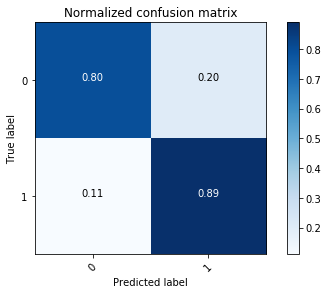

              precision    recall  f1-score   support

           0       0.92      0.80      0.86      7128
           1       0.72      0.89      0.80      4187

   micro avg       0.83      0.83      0.83     11315
   macro avg       0.82      0.84      0.83     11315
weighted avg       0.85      0.83      0.83     11315

2019-04-07 09:09:30


Iteration: 1
[ 5 19 10  7  4 17  2 16 11  9  8 14  3  6 12  1]
[0, 13, 15, 18]
         0         1         2    3         4         5         6         7   \
0  0.151007  0.053691  0.030201  0.0  0.060403  0.127517  0.036913  0.030201   

         8         9         10        11        12        13        14  \
0  0.020134  0.063758  0.144295  0.033557  0.003356  0.010067  0.050336   

         15  
0  0.184564  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.85 0.15]
 [0.08 0.92]]


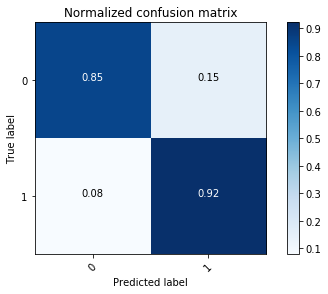

              precision    recall  f1-score   support

           0       0.96      0.85      0.90      7562
           1       0.71      0.92      0.80      3032

   micro avg       0.87      0.87      0.87     10594
   macro avg       0.84      0.89      0.85     10594
weighted avg       0.89      0.87      0.87     10594

2019-04-07 09:11:38


Iteration: 2
[18  1 10 17  2  5  8 11  6 13 15 14 12 19  4 16]
[0, 3, 7, 9]
         0         1         2    3         4         5         6         7   \
0  0.151007  0.053691  0.030201  0.0  0.060403  0.127517  0.036913  0.030201   

         8         9         10        11        12        13        14  \
0  0.020134  0.063758  0.144295  0.033557  0.003356  0.010067  0.050336   

         15  
0  0.184564  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.85 0.15]
 [0.11 0.89]]


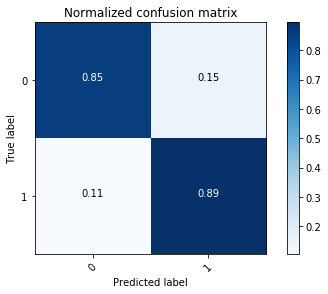

              precision    recall  f1-score   support

           0       0.94      0.85      0.89      7570
           1       0.76      0.89      0.82      3872

   micro avg       0.87      0.87      0.87     11442
   macro avg       0.85      0.87      0.86     11442
weighted avg       0.88      0.87      0.87     11442

2019-04-07 09:13:42


Iteration: 3
[ 8 19 16  0 14  4  9 18  6 13  3 15  2  7 12 17]
[1, 5, 10, 11]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.85 0.15]
 [0.15 0.85]]


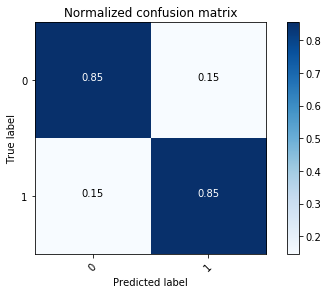

              precision    recall  f1-score   support

           0       0.90      0.85      0.88      7837
           1       0.78      0.85      0.82      4803

   micro avg       0.85      0.85      0.85     12640
   macro avg       0.84      0.85      0.85     12640
weighted avg       0.86      0.85      0.86     12640

2019-04-07 09:15:46


Iteration: 4
[19  5 14 13 12  0  8  7 16  4  3 17 15  9  2 10]
[1, 6, 11, 18]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.88 0.12]
 [0.19 0.81]]


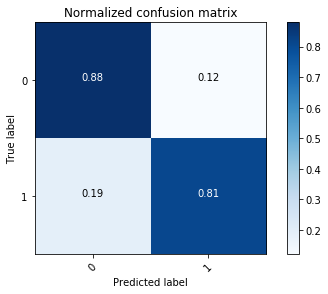

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      8516
           1       0.77      0.81      0.79      4180

   micro avg       0.86      0.86      0.86     12696
   macro avg       0.84      0.84      0.84     12696
weighted avg       0.86      0.86      0.86     12696

2019-04-07 09:17:55


Iteration: 5
[ 3  7 16 13 14  6  8  9  2 19 17  4 11 10  0 12]
[1, 5, 15, 18]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.88 0.12]
 [0.08 0.92]]


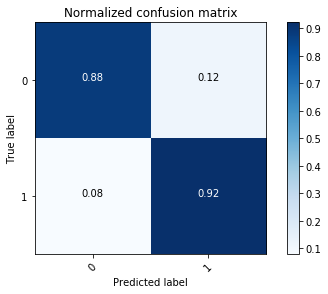

              precision    recall  f1-score   support

           0       0.96      0.88      0.92      8578
           1       0.79      0.92      0.85      4152

   micro avg       0.90      0.90      0.90     12730
   macro avg       0.88      0.90      0.89     12730
weighted avg       0.91      0.90      0.90     12730

2019-04-07 09:20:09


Iteration: 6
[ 3  7 14  0  4 19 10 12 13 11  2  5 16  8 17  9]
[1, 6, 15, 18]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.9  0.1 ]
 [0.09 0.91]]


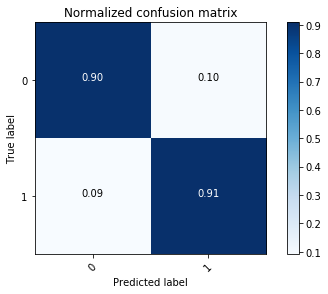

              precision    recall  f1-score   support

           0       0.96      0.90      0.93      9204
           1       0.81      0.91      0.86      4131

   micro avg       0.91      0.91      0.91     13335
   macro avg       0.88      0.91      0.89     13335
weighted avg       0.91      0.91      0.91     13335

2019-04-07 09:22:22


Iteration: 7
[17 14 19  9  3 12  8  4  2 15  6 10  7  0  1 11]
[5, 13, 16, 18]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.92 0.08]
 [0.16 0.84]]


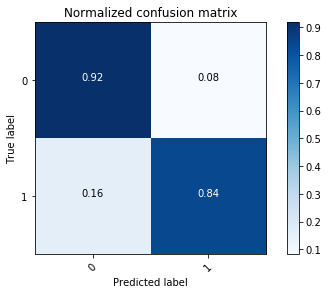

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      6563
           1       0.84      0.84      0.84      3407

   micro avg       0.89      0.89      0.89      9970
   macro avg       0.88      0.88      0.88      9970
weighted avg       0.89      0.89      0.89      9970

2019-04-07 09:24:43


Iteration: 8
[ 3  7 15 11 17 13 12  5  6 19 10 14 16  8 18  0]
[1, 2, 4, 9]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.92 0.08]
 [0.15 0.85]]


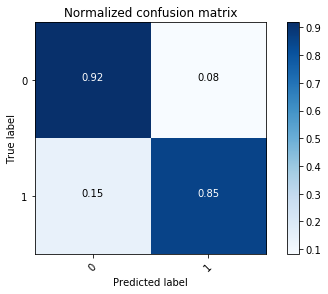

              precision    recall  f1-score   support

           0       0.89      0.92      0.91      7148
           1       0.88      0.85      0.87      5258

   micro avg       0.89      0.89      0.89     12406
   macro avg       0.89      0.89      0.89     12406
weighted avg       0.89      0.89      0.89     12406

2019-04-07 09:26:49


Iteration: 9
[ 7 17  6 13  5  9  8  3 19  0  2 10  4 11  1 12]
[14, 15, 16, 18]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.86 0.14]
 [0.15 0.85]]


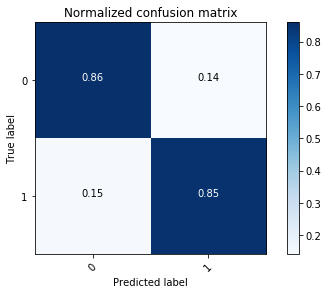

              precision    recall  f1-score   support

           0       0.93      0.86      0.89      8568
           1       0.72      0.85      0.78      3588

   micro avg       0.86      0.86      0.86     12156
   macro avg       0.83      0.86      0.84     12156
weighted avg       0.87      0.86      0.86     12156

2019-04-07 09:43:54

   sensitivity  specificity  accuracy
0     0.889420     0.795875  0.830490
1     0.921174     0.849114  0.869738
2     0.894628     0.852312  0.866632
3     0.853425     0.854536  0.854114
4     0.810287     0.879403  0.856648
5     0.921965     0.884006  0.896386
6     0.908739     0.904933  0.906112
7     0.837687     0.917111  0.889970
8     0.853556     0.918159  0.890779
9     0.852843     0.859594  0.857601
avg sensitivity: 0.8743724429499119
avg specificity: 0.8715042893238492
avg accuracy: 0.8718469455980999


In [10]:
## do multiple iterations
sensitivity = []
specificity = []
accuracy = []
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

for i in range(10):
    print('')    
    print("Iteration: " + str(i))
    
    Train, Test = CreateTrainTestID(dfull)
    X_train1, y_train1, X_test, y_test = createXYsets(Train,Test)
    print('')
    
    ### data scaling ###
    scaler = StandardScaler().fit(X_train1)  # StandardScaler();  MinMaxScaler()
    X_train_scaled = scaler.transform(X_train1)    # fit_transform(X_train1)
    X_test_scaled = scaler.transform(X_test)
    
    ## model fitting
    model_svc = SVC(class_weight='balanced')  # probability=True
    model_svc.fit(X_train_scaled, y_train1)
    
    
    ## predict on test data - check metrics
    y_pred = model_svc.predict(X_test_scaled)
    
    
    #####    Compute confusion matrix     ####
    class_names = ['0','1'] #['wake','sleep_stage_1','sleep_stage_2']  # wake, SS1, SS2  ; # '0','1','2'
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    #print(cnf_matrix)
    # Plot normalized confusion matrix : normalisation shows nan for class'0' no signal has class=0 as true label
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()
    
    ## print metrics
    print(classification_report(y_test, y_pred, target_names=class_names))
    #print('accuracy: ' + str(accuracy_score(y_test,y_pred)))
    p = precision_recall_fscore_support(y_test,y_pred)
    #sen = p[1][1]
    #spec = p[1][0]
    #print('sen: ' + str(sen) +' , spec: ' + str(spec))
    sensitivity.append(p[1][1])
    specificity.append(p[1][0])
    accuracy.append(accuracy_score(y_test,y_pred))
    
    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    print('')

sensitivity = pd.DataFrame(sensitivity)
specificity = pd.DataFrame(specificity)
accuracy = pd.DataFrame(accuracy)
metrics = pd.concat([sensitivity, specificity, accuracy], axis=1)
metrics.columns = ['sensitivity', 'specificity', 'accuracy']
print(metrics)
print('avg sensitivity: ' + str(metrics.sensitivity.mean()))
print('avg specificity: ' + str(metrics.specificity.mean()))
print('avg accuracy: ' + str(metrics.accuracy.mean()))    

2019-04-10 07:58:17
TRAIN: ['401' '402' '403' '404' '405' '406' '407' '408' '409' '410' '411' '412'
 '413' '414' '415' '416' '418' '419'] TEST: ['400' '417']


C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.48 0.52]
 [0.02 0.98]]


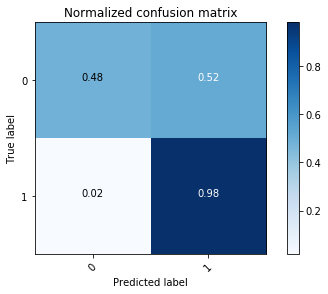

              precision    recall  f1-score   support

           0       0.98      0.48      0.65      4234
           1       0.45      0.98      0.62      1820

   micro avg       0.63      0.63      0.63      6054
   macro avg       0.72      0.73      0.63      6054
weighted avg       0.82      0.63      0.64      6054

2019-04-10 08:00:40

TRAIN: ['400' '402' '403' '404' '405' '406' '407' '408' '409' '410' '411' '412'
 '413' '414' '416' '417' '418' '419'] TEST: ['401' '415']


C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.89 0.11]
 [0.08 0.92]]


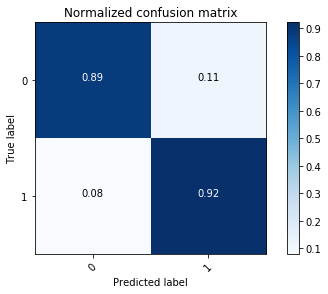

              precision    recall  f1-score   support

           0       0.96      0.89      0.92      4820
           1       0.79      0.92      0.85      2303

   micro avg       0.90      0.90      0.90      7123
   macro avg       0.88      0.90      0.89      7123
weighted avg       0.91      0.90      0.90      7123

2019-04-10 08:03:57

TRAIN: ['400' '401' '402' '403' '404' '406' '407' '409' '410' '411' '412' '413'
 '414' '415' '416' '417' '418' '419'] TEST: ['405' '408']


C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.86 0.14]
 [0.07 0.93]]


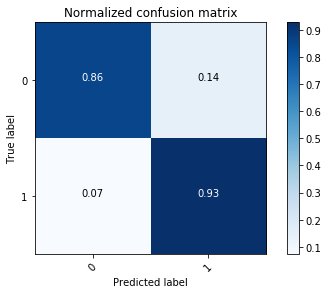

              precision    recall  f1-score   support

           0       0.96      0.86      0.91      3729
           1       0.74      0.93      0.83      1689

   micro avg       0.88      0.88      0.88      5418
   macro avg       0.85      0.89      0.87      5418
weighted avg       0.89      0.88      0.88      5418

2019-04-10 08:06:55

TRAIN: ['400' '401' '402' '404' '405' '406' '407' '408' '409' '410' '412' '413'
 '414' '415' '416' '417' '418' '419'] TEST: ['403' '411']


C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.77 0.23]
 [0.26 0.74]]


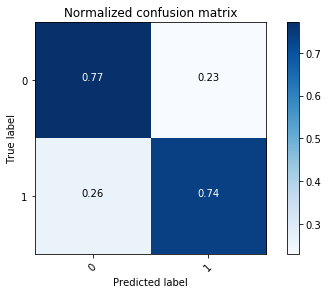

              precision    recall  f1-score   support

           0       0.86      0.77      0.81      3986
           1       0.61      0.74      0.67      1920

   micro avg       0.76      0.76      0.76      5906
   macro avg       0.73      0.75      0.74      5906
weighted avg       0.78      0.76      0.76      5906

2019-04-10 08:09:27

TRAIN: ['400' '401' '402' '403' '404' '405' '406' '407' '408' '409' '410' '411'
 '412' '413' '414' '415' '417' '419'] TEST: ['416' '418']


C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.95 0.05]
 [0.24 0.76]]


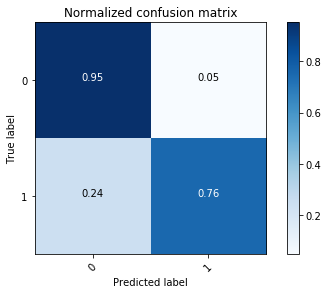

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      3916
           1       0.88      0.76      0.81      1862

   micro avg       0.89      0.89      0.89      5778
   macro avg       0.89      0.85      0.87      5778
weighted avg       0.89      0.89      0.89      5778

2019-04-10 08:12:13

TRAIN: ['400' '401' '403' '404' '405' '406' '407' '408' '409' '410' '411' '412'
 '414' '415' '416' '417' '418' '419'] TEST: ['402' '413']


C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.92 0.08]
 [0.17 0.83]]


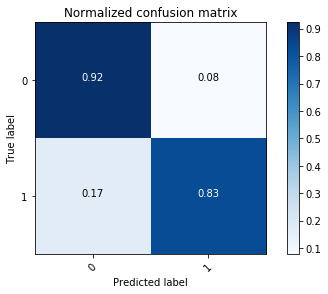

              precision    recall  f1-score   support

           0       0.91      0.92      0.92      3271
           1       0.85      0.83      0.84      1779

   micro avg       0.89      0.89      0.89      5050
   macro avg       0.88      0.88      0.88      5050
weighted avg       0.89      0.89      0.89      5050

2019-04-10 08:15:12

TRAIN: ['400' '401' '402' '403' '404' '405' '406' '407' '408' '410' '411' '412'
 '413' '414' '415' '416' '417' '418'] TEST: ['409' '419']


C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.79 0.21]
 [0.1  0.9 ]]


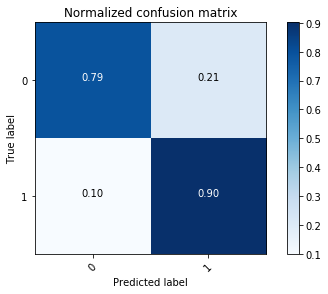

              precision    recall  f1-score   support

           0       0.84      0.79      0.82      1766
           1       0.87      0.90      0.88      2630

   micro avg       0.86      0.86      0.86      4396
   macro avg       0.86      0.85      0.85      4396
weighted avg       0.86      0.86      0.86      4396

2019-04-10 08:18:04

TRAIN: ['400' '401' '402' '403' '405' '406' '407' '408' '409' '410' '411' '413'
 '414' '415' '416' '417' '418' '419'] TEST: ['404' '412']


C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.82 0.18]
 [0.09 0.91]]


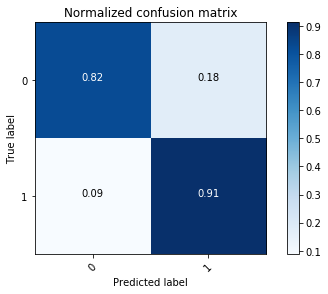

              precision    recall  f1-score   support

           0       0.92      0.82      0.87      3073
           1       0.80      0.91      0.85      2356

   micro avg       0.86      0.86      0.86      5429
   macro avg       0.86      0.87      0.86      5429
weighted avg       0.87      0.86      0.86      5429

2019-04-10 08:20:50

TRAIN: ['400' '401' '402' '403' '404' '405' '406' '408' '409' '411' '412' '413'
 '414' '415' '416' '417' '418' '419'] TEST: ['407' '410']


C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.94 0.06]
 [0.11 0.89]]


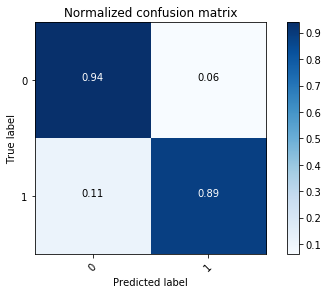

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      4326
           1       0.89      0.89      0.89      2428

   micro avg       0.92      0.92      0.92      6754
   macro avg       0.91      0.91      0.91      6754
weighted avg       0.92      0.92      0.92      6754

2019-04-10 08:23:33

TRAIN: ['400' '401' '402' '403' '404' '405' '407' '408' '409' '410' '411' '412'
 '413' '415' '416' '417' '418' '419'] TEST: ['406' '414']


C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.81 0.19]
 [0.05 0.95]]


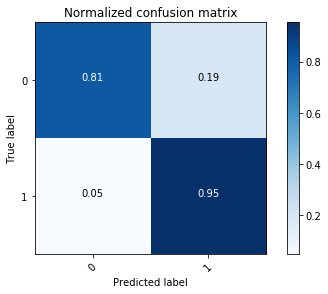

              precision    recall  f1-score   support

           0       0.98      0.81      0.89      4445
           1       0.67      0.95      0.79      1816

   micro avg       0.85      0.85      0.85      6261
   macro avg       0.82      0.88      0.84      6261
weighted avg       0.89      0.85      0.86      6261

2019-04-10 08:26:26

   sensitivity  specificity  accuracy
0     0.981319     0.481342  0.631648
1     0.921407     0.885062  0.896813
2     0.927176     0.855994  0.878184
3     0.736979     0.770948  0.759905
4     0.755639     0.950970  0.888024
5     0.829117     0.922959  0.889901
6     0.901521     0.794451  0.858508
7     0.912139     0.824601  0.862590
8     0.885091     0.938974  0.919603
9     0.953194     0.810799  0.852100
avg sensitivity: 0.8803581705489216
avg specificity: 0.8236099763097118
avg accuracy: 0.8437276209308504


In [10]:
from sklearn.model_selection import KFold, cross_validate, cross_val_score
pid_tr = dfull['pID'].unique() 
K = 10
kf = KFold(n_splits=K,shuffle=True,random_state=42)
dn = dfull
sensitivity = []
specificity = []
accuracy = []
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))


for train_index, test_index in kf.split(pid_tr):
    print("TRAIN:", pid_tr[train_index], "TEST:", pid_tr[test_index])
    
    df_test = pd.DataFrame()
    df_train = pd.DataFrame()
    for pid in train_index:
        df_tr = dn[(dn['pID']==pid_tr[pid])]
        df_train = pd.concat([df_train,df_tr])
    for pid in test_index:
        df_ts = dn[(dn['pID']==pid_tr[pid])]
        df_test = pd.concat([df_test,df_ts], ignore_index = True)
    
    X_train = df_train.drop(['pID', 'day', 'epoch','class_label', 'class2'],1).reset_index()
    X_train = X_train.drop(['index'],1)
        
    y_train = df_train['class2'].reset_index()
    y_train = y_train.drop(['index'],1)
    
    X_test = df_test.drop(['pID', 'day', 'epoch','class_label', 'class2'],1).reset_index()
    X_test = X_test.drop(['index'],1)
    
    y_test = df_test[['class2']].reset_index()
    y_test = y_test.drop(['index'],1)
    
    ### data scaling ###
    scaler = StandardScaler().fit(X_train)  # StandardScaler();  MinMaxScaler()
    X_train_scaled = scaler.transform(X_train)    # fit_transform(X_train1)
    X_test_scaled = scaler.transform(X_test)
    
    ## model fitting
    model_svc = SVC(class_weight='balanced')  # probability=True
    model_svc.fit(X_train_scaled, y_train)
    
    
    ## predict on test data - check metrics
    y_pred = model_svc.predict(X_test_scaled)
    
    
    #####    Compute confusion matrix     ####
    class_names = ['0','1'] #['wake','sleep_stage_1','sleep_stage_2']  # wake, SS1, SS2  ; # '0','1','2'
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    #print(cnf_matrix)
    # Plot normalized confusion matrix : normalisation shows nan for class'0' no signal has class=0 as true label
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()
    
    ## print metrics
    print(classification_report(y_test, y_pred, target_names=class_names))
    #print('accuracy: ' + str(accuracy_score(y_test,y_pred)))
    p = precision_recall_fscore_support(y_test,y_pred)
    #sen = p[1][1]
    #spec = p[1][0]
    #print('sen: ' + str(sen) +' , spec: ' + str(spec))
    sensitivity.append(p[1][1])
    specificity.append(p[1][0])
    accuracy.append(accuracy_score(y_test,y_pred))
    
    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    print('')

sensitivity = pd.DataFrame(sensitivity)
specificity = pd.DataFrame(specificity)
accuracy = pd.DataFrame(accuracy)
metrics = pd.concat([sensitivity, specificity, accuracy], axis=1)
metrics.columns = ['sensitivity', 'specificity', 'accuracy']
print(metrics)
print('avg sensitivity: ' + str(metrics.sensitivity.mean()))
print('avg specificity: ' + str(metrics.specificity.mean()))
print('avg accuracy: ' + str(metrics.accuracy.mean()))    

In [ ]:
############# TRY PARAMATER OPTIMISATIONS ####################

## do 5-fold CV
## inside cross-validation, split into train, validation & test indices
## do calc on train & val to get optimal params
#     try :
#     balance with smote / balanced class weight in SVM
#     grid search + CV  -> show plots on train & val error
#     optimise prob thres


In [14]:
#'''
# https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65
# c=10,g=0.1 ; c=0.1,g=1 ; c=1,g=0.01 ; c=10,g=0.01  -> from older runs

from sklearn.metrics import make_scorer,recall_score,accuracy_score,precision_score   #roc_curve, precision_recall_curve, auc, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold   # train_test_split,

clf = SVC(class_weight='balanced') #n_jobs=-1)  # this runs the computation in parallel

param_grid = [
  #{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [0.01, 0.1, 1, 10], 'gamma': [0.01, 0.1], 'kernel': ['rbf']},
 ]


scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}



def grid_search_wrapper(refit_score='recall_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits = 4)
    grid_search_clf = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search_clf.fit(X_train_scaled, y_train.values)  # X_train.values
    print('grid done!')

    print('Best params for {}'.format(refit_score))
    print(grid_search_clf.best_params_)
    
    results = pd.DataFrame(grid_search_clf.cv_results_)
    results = results[['param_C','param_gamma','mean_train_recall_score','mean_test_recall_score','mean_train_accuracy_score','mean_test_accuracy_score','mean_train_precision_score','mean_test_precision_score']] 
   
    
    # make the predictions
    y_pred = grid_search_clf.predict(X_test_scaled.values)

    # confusion matrix on the test data.
    print('\nConfusion matrix of SVM optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search_clf, results
#'''

In [15]:
## check a single iteration of train-test; the train is further split into train_val 4 times (n_splits = 4)

Train, Test = CreateTrainTestID(dfull)
X_train, y_train, X_test, y_test = createXYsets(Train,Test)
print('')
    
### data scaling ###
scaler = StandardScaler().fit(X_train)  # StandardScaler();  MinMaxScaler()
X_train_scaled = scaler.transform(X_train)    # fit_transform(X_train1)
X_test_scaled = scaler.transform(X_test)

print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
print('')

### run grid search ###
grid_search_clf, results = grid_search_wrapper(refit_score='recall_score')

print('')
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

[ 5 15 16  9  2 14 17 18  0  8  7  1 10  4  6  3]
[11, 12, 13, 19]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  

2019-04-07 10:52:53



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


grid done!
Best params for recall_score
{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}

Confusion matrix of SVM optimized for recall_score on the test data:
     pred_neg  pred_pos
neg      5094         0
pos      3859         0

2019-04-07 11:25:05


In [29]:
y_pred_grid = grid_search_clf.predict(X_test_scaled)
print(pd.DataFrame(confusion_matrix(y_test, y_pred_grid),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))

print(classification_report(y_test, y_pred, target_names=class_names))

     pred_neg  pred_pos
neg      6874      1049
pos       449      3290
              precision    recall  f1-score   support

           0       0.94      0.85      0.89      7923
           1       0.73      0.88      0.80      3739

   micro avg       0.86      0.86      0.86     11662
   macro avg       0.83      0.86      0.84     11662
weighted avg       0.87      0.86      0.86     11662



In [33]:
grid_search_clf.cv_results_

{'mean_fit_time': array([107.2 , 100.5 ,  88.45,  83.24,  71.02,  84.26,  77.56, 218.8 ]),
 'std_fit_time': array([ 6.75,  8.22,  8.57,  8.99,  7.42, 13.57,  7.25, 34.23]),
 'mean_score_time': array([40.57, 33.87, 28.23, 27.63, 26.78, 28.87, 27.36, 25.95]),
 'std_score_time': array([2.71, 1.76, 2.01, 1.95, 1.93, 4.58, 4.85, 2.66]),
 'param_C': masked_array(data=[0.01, 0.01, 0.1, 0.1, 1, 1, 10, 10],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_gamma': masked_array(data=[0.01, 0.1, 0.01, 0.1, 0.01, 0.1, 0.01, 0.1],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_kernel': masked_array(data=['rbf', 'rbf', 'rbf', 'rbf', 'rbf', 'rbf', 'rbf', 'rbf'],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.01, 'gamma': 0.01,

In [16]:
## sort by different metrics ##
results = results.sort_values(by='mean_test_precision_score', ascending=False)
results

,param_C,param_gamma,mean_train_recall_score,mean_test_recall_score,mean_train_accuracy_score,mean_test_accuracy_score,mean_train_precision_score,mean_test_precision_score
2,0.1,0.01,0.883580,0.879957,0.862734,0.854336,0.755586,0.748278
0,0.01,0.01,0.871894,0.869505,0.855819,0.849967,0.747418,0.746422
1,0.01,0.1,0.880992,0.876732,0.859863,0.850963,0.751261,0.742521
4,1,0.01,0.898571,0.894290,0.864549,0.854031,0.752544,0.740183
3,0.1,0.1,0.899108,0.891185,0.866954,0.853198,0.756890,0.740104
7,10,0.1,0.937729,0.876433,0.900500,0.847712,0.803528,0.734886
5,1,0.1,0.916746,0.895843,0.875413,0.851410,0.765022,0.734292
6,10,0.01,0.910893,0.902413,0.864651,0.851491,0.747726,0.731847


In [31]:
## sort by different metrics ##
results = results.sort_values(by='mean_train_recall_score', ascending=False)
results.reset_index()

,index,param_C,param_gamma,mean_train_recall_score,mean_test_recall_score,mean_train_accuracy_score,mean_test_accuracy_score,mean_train_precision_score,mean_test_precision_score
0,7,10,0.1,0.937729,0.876433,0.900500,0.847712,0.803528,0.734886
1,5,1,0.1,0.916746,0.895843,0.875413,0.851410,0.765022,0.734292
2,6,10,0.01,0.910893,0.902413,0.864651,0.851491,0.747726,0.731847
3,3,0.1,0.1,0.899108,0.891185,0.866954,0.853198,0.756890,0.740104
4,4,1,0.01,0.898571,0.894290,0.864549,0.854031,0.752544,0.740183
5,2,0.1,0.01,0.883580,0.879957,0.862734,0.854336,0.755586,0.748278
6,1,0.01,0.1,0.880992,0.876732,0.859863,0.850963,0.751261,0.742521
7,0,0.01,0.01,0.871894,0.869505,0.855819,0.849967,0.747418,0.746422


C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  This is separate from the ipykernel package so we can avoid doing imports until


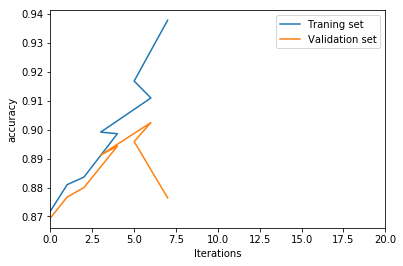

In [32]:
# dataframe & plots
fig, ax2 = plt.subplots(1, 1)
ax2.hold(True)
ax2.plot(results['mean_train_recall_score'],label='Traning set')
ax2.plot(results['mean_test_recall_score'],label='Validation set')
#ax2.set_title("Training and Validation precision")
ax2.set_ylabel("accuracy")
ax2.set_xlabel("Iterations")
ax2.set_xlim([0,20])
ax2.legend(fancybox=True)

C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  


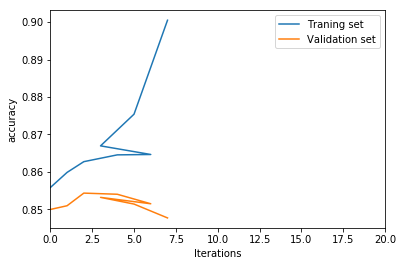

In [18]:
## sort by different metrics ##
results = results.sort_values(by='mean_train_accuracy_score', ascending=False)

# dataframe & plots
fig, ax2 = plt.subplots(1, 1)
ax2.hold(True)
ax2.plot(results['mean_train_accuracy_score'],label='Traning set')
ax2.plot(results['mean_test_accuracy_score'],label='Validation set')
#ax2.set_title("Training and Validation precision")
ax2.set_ylabel("accuracy")
ax2.set_xlabel("Iterations")
ax2.set_xlim([0,20])
ax2.legend(fancybox=True)

In [19]:
results

,param_C,param_gamma,mean_train_recall_score,mean_test_recall_score,mean_train_accuracy_score,mean_test_accuracy_score,mean_train_precision_score,mean_test_precision_score
7,10,0.1,0.937729,0.876433,0.900500,0.847712,0.803528,0.734886
5,1,0.1,0.916746,0.895843,0.875413,0.851410,0.765022,0.734292
3,0.1,0.1,0.899108,0.891185,0.866954,0.853198,0.756890,0.740104
6,10,0.01,0.910893,0.902413,0.864651,0.851491,0.747726,0.731847
4,1,0.01,0.898571,0.894290,0.864549,0.854031,0.752544,0.740183
2,0.1,0.01,0.883580,0.879957,0.862734,0.854336,0.755586,0.748278
1,0.01,0.1,0.880992,0.876732,0.859863,0.850963,0.751261,0.742521
0,0.01,0.01,0.871894,0.869505,0.855819,0.849967,0.747418,0.746422


2019-04-07 11:42:43

Iteration: 0
[ 6 16  3 14 17  8  2  5 10  1 12  4 19 11  9  7]
[0, 13, 15, 18]
         0         1         2    3         4         5         6         7   \
0  0.151007  0.053691  0.030201  0.0  0.060403  0.127517  0.036913  0.030201   

         8         9         10        11        12        13        14  \
0  0.020134  0.063758  0.144295  0.033557  0.003356  0.010067  0.050336   

         15  
0  0.184564  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.84 0.16]
 [0.08 0.92]]


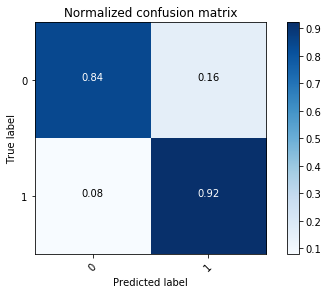

              precision    recall  f1-score   support

           0       0.96      0.84      0.90      7562
           1       0.70      0.92      0.79      3032

   micro avg       0.86      0.86      0.86     10594
   macro avg       0.83      0.88      0.85     10594
weighted avg       0.89      0.86      0.87     10594

2019-04-07 11:44:04


Iteration: 1
[ 0  7  6 11 10  1  2  3 19 17 15  5  4 13  8 16]
[9, 12, 14, 18]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.85 0.15]
 [0.1  0.9 ]]


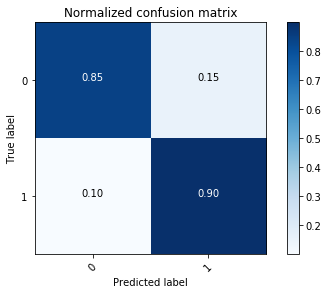

              precision    recall  f1-score   support

           0       0.94      0.85      0.89      7009
           1       0.76      0.90      0.82      3796

   micro avg       0.86      0.86      0.86     10805
   macro avg       0.85      0.87      0.86     10805
weighted avg       0.88      0.86      0.87     10805

2019-04-07 11:45:16


Iteration: 2
[ 5  6  7 15 14  2  0  8  1 19  9 13 10 16 18 17]
[3, 4, 11, 12]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.79 0.21]
 [0.16 0.84]]


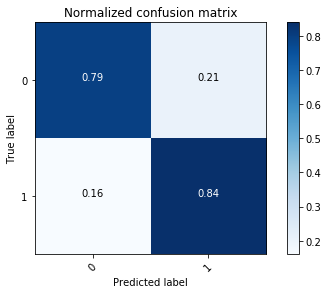

              precision    recall  f1-score   support

           0       0.89      0.79      0.84      7059
           1       0.71      0.84      0.77      4276

   micro avg       0.81      0.81      0.81     11335
   macro avg       0.80      0.82      0.80     11335
weighted avg       0.82      0.81      0.81     11335

2019-04-07 11:46:18


Iteration: 3
[18 13  5 17  3 11  1  2  0 15  9 10 16 14 19  7]
[4, 6, 8, 12]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.87 0.13]
 [0.09 0.91]]


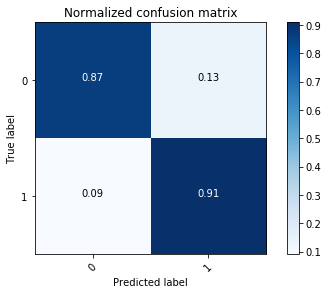

              precision    recall  f1-score   support

           0       0.95      0.87      0.90      7428
           1       0.79      0.91      0.84      4024

   micro avg       0.88      0.88      0.88     11452
   macro avg       0.87      0.89      0.87     11452
weighted avg       0.89      0.88      0.88     11452

2019-04-07 11:47:30


Iteration: 4
[12  2  4 16  7  9 17  6 14 19  5  0 15  3 18  8]
[1, 10, 11, 13]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.87 0.13]
 [0.16 0.84]]


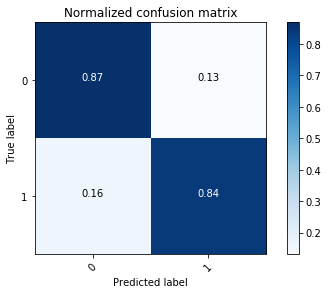

              precision    recall  f1-score   support

           0       0.90      0.87      0.88      7148
           1       0.80      0.84      0.82      4366

   micro avg       0.86      0.86      0.86     11514
   macro avg       0.85      0.85      0.85     11514
weighted avg       0.86      0.86      0.86     11514

2019-04-07 11:48:41


Iteration: 5
[ 8  9  1  5 16 18  0  3 15 10 13  6  7 14 19 17]
[2, 4, 11, 12]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.83 0.17]
 [0.21 0.79]]


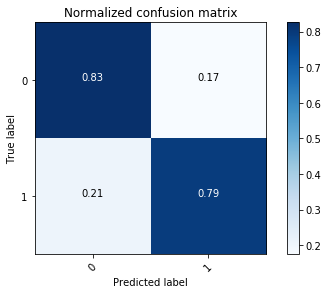

              precision    recall  f1-score   support

           0       0.86      0.83      0.84      7178
           1       0.74      0.79      0.77      4510

   micro avg       0.81      0.81      0.81     11688
   macro avg       0.80      0.81      0.81     11688
weighted avg       0.82      0.81      0.81     11688

2019-04-07 11:49:46


Iteration: 6
[13 12 14  4 15  3 19  6 18  7 11  0  2  8  1 17]
[5, 9, 10, 16]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.91 0.09]
 [0.15 0.85]]


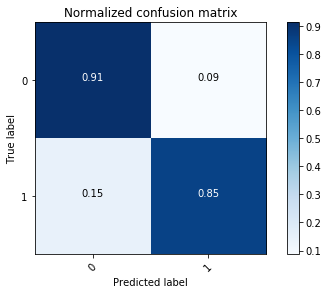

              precision    recall  f1-score   support

           0       0.90      0.91      0.91      6647
           1       0.87      0.85      0.86      4628

   micro avg       0.89      0.89      0.89     11275
   macro avg       0.89      0.88      0.88     11275
weighted avg       0.89      0.89      0.89     11275

2019-04-07 11:50:50


Iteration: 7
[12  6  9 13  5 15  2  3 18  8 17 10  0 16 11  4]
[1, 7, 14, 19]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.83 0.17]
 [0.06 0.94]]


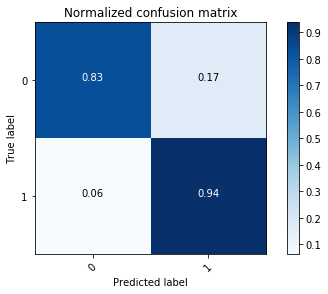

              precision    recall  f1-score   support

           0       0.95      0.83      0.89      7409
           1       0.78      0.94      0.85      4694

   micro avg       0.87      0.87      0.87     12103
   macro avg       0.87      0.89      0.87     12103
weighted avg       0.89      0.87      0.88     12103

2019-04-07 11:52:08


Iteration: 8
[11 13  1  4  8  7  2  5 10 14 18 16 15  9  0  3]
[6, 12, 17, 19]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.63 0.37]
 [0.04 0.96]]


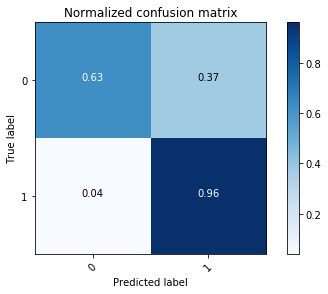

              precision    recall  f1-score   support

           0       0.96      0.63      0.76      6838
           1       0.62      0.96      0.76      4426

   micro avg       0.76      0.76      0.76     11264
   macro avg       0.79      0.79      0.76     11264
weighted avg       0.83      0.76      0.76     11264

2019-04-07 11:53:34


Iteration: 9
[15  3 17 18  8  4 10  7  1  5 19  2 11  0 13  9]
[6, 12, 14, 16]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.85 0.15]
 [0.12 0.88]]


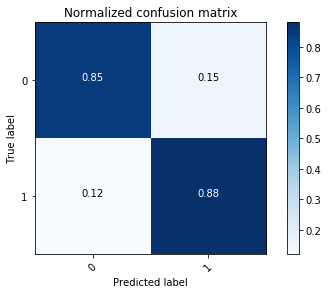

              precision    recall  f1-score   support

           0       0.94      0.85      0.89      7923
           1       0.73      0.88      0.80      3739

   micro avg       0.86      0.86      0.86     11662
   macro avg       0.83      0.86      0.84     11662
weighted avg       0.87      0.86      0.86     11662

2019-04-07 11:54:40

   sensitivity  specificity  accuracy
0     0.921504     0.840783  0.863885
1     0.899104     0.845342  0.864230
2     0.839102     0.794163  0.811116
3     0.909294     0.865778  0.881069
4     0.838983     0.868914  0.857565
5     0.794235     0.825578  0.813484
6     0.852420     0.913194  0.888248
7     0.937154     0.834526  0.874329
8     0.960687     0.625622  0.757280
9     0.880182     0.845765  0.856800
avg sensitivity: 0.8832665143748549
avg specificity: 0.8259665237049354
avg accuracy: 0.8468004889891487


In [27]:
# input parameters: 10,0.01 ; #1,0.01
## do multiple iterations
sensitivity = []
specificity = []
accuracy = []
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

for i in range(10):
    print('')    
    print("Iteration: " + str(i))
    
    Train, Test = CreateTrainTestID(dfull)
    X_train1, y_train1, X_test, y_test = createXYsets(Train,Test)
    print('')
    
    ### data scaling ###
    scaler = StandardScaler().fit(X_train1)  # StandardScaler();  MinMaxScaler()
    X_train_scaled = scaler.transform(X_train1)    # fit_transform(X_train1)
    X_test_scaled = scaler.transform(X_test)
    
    ## model fitting
    model1_svc = SVC(C= 10, gamma= 0.01, kernel= 'rbf', class_weight='balanced')  # probability=True
    model1_svc.fit(X_train_scaled, y_train1)
    
    
    ## predict on test data - check metrics
    y_pred = model1_svc.predict(X_test_scaled)
    
    
    #####    Compute confusion matrix     ####
    class_names = ['0','1'] #['wake','sleep_stage_1','sleep_stage_2']  # wake, SS1, SS2  ; # '0','1','2'
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    #print(cnf_matrix)
    # Plot normalized confusion matrix : normalisation shows nan for class'0' no signal has class=0 as true label
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()
    
    ## print metrics
    print(classification_report(y_test, y_pred, target_names=class_names))
    #print('accuracy: ' + str(accuracy_score(y_test,y_pred)))
    p = precision_recall_fscore_support(y_test,y_pred)
    #sen = p[1][1]
    #spec = p[1][0]
    #print('sen: ' + str(sen) +' , spec: ' + str(spec))
    sensitivity.append(p[1][1])
    specificity.append(p[1][0])
    accuracy.append(accuracy_score(y_test,y_pred))
    
    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    print('')

sensitivity = pd.DataFrame(sensitivity)
specificity = pd.DataFrame(specificity)
accuracy = pd.DataFrame(accuracy)
metrics = pd.concat([sensitivity, specificity, accuracy], axis=1)
metrics.columns = ['sensitivity', 'specificity', 'accuracy']
print(metrics)
print('avg sensitivity: ' + str(metrics.sensitivity.mean()))
print('avg specificity: ' + str(metrics.specificity.mean()))
print('avg accuracy: ' + str(metrics.accuracy.mean()))    

2019-04-07 11:59:17

Iteration: 0
[ 1 12 15  7 13  4  2  9  3  5  6  0 10 18 17 11]
[8, 14, 16, 19]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.83 0.17]
 [0.12 0.88]]


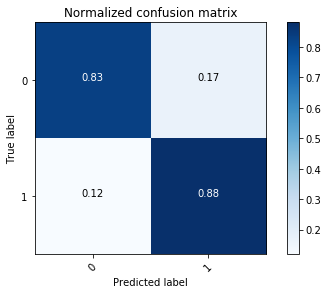

              precision    recall  f1-score   support

           0       0.92      0.83      0.87      6688
           1       0.76      0.88      0.81      4005

   micro avg       0.85      0.85      0.85     10693
   macro avg       0.84      0.86      0.84     10693
weighted avg       0.86      0.85      0.85     10693

2019-04-07 12:00:38


Iteration: 1
[ 6  0  3 14  2 18 17 19 13  7  9  8  5 12  4 10]
[1, 11, 15, 16]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.87 0.13]
 [0.24 0.76]]


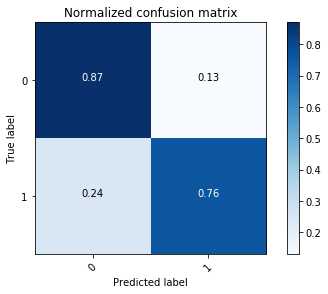

              precision    recall  f1-score   support

           0       0.88      0.87      0.87      8459
           1       0.75      0.76      0.75      4236

   micro avg       0.83      0.83      0.83     12695
   macro avg       0.81      0.81      0.81     12695
weighted avg       0.83      0.83      0.83     12695

2019-04-07 12:01:48


Iteration: 2
[ 8  4  2  9 11 17 10 16 12  7  6 13  3 18  5 15]
[0, 1, 14, 19]
        0         1    2    3        4         5         6         7   \
0  0.16443  0.050336  0.0  0.0  0.04698  0.194631  0.060403  0.006711   

         8         9         10        11   12        13        14        15  
0  0.003356  0.053691  0.151007  0.053691  0.0  0.010067  0.053691  0.151007  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.77 0.23]
 [0.04 0.96]]


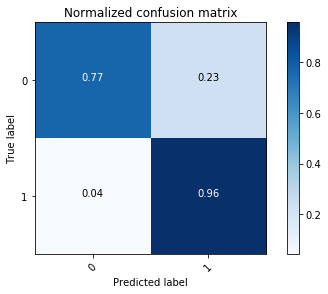

              precision    recall  f1-score   support

           0       0.97      0.77      0.86      7112
           1       0.72      0.96      0.82      4466

   micro avg       0.84      0.84      0.84     11578
   macro avg       0.84      0.86      0.84     11578
weighted avg       0.87      0.84      0.84     11578

2019-04-07 12:03:10


Iteration: 3
[ 4  9  1  7  5  6 17 16 11 10 18 14 15  3  2 12]
[0, 8, 13, 19]
         0         1         2    3         4         5         6         7   \
0  0.151007  0.053691  0.030201  0.0  0.060403  0.127517  0.036913  0.030201   

         8         9         10        11        12        13        14  \
0  0.020134  0.063758  0.144295  0.033557  0.003356  0.010067  0.050336   

         15  
0  0.184564  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.8  0.2 ]
 [0.06 0.94]]


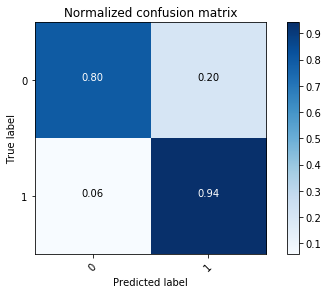

              precision    recall  f1-score   support

           0       0.96      0.80      0.87      5682
           1       0.74      0.94      0.83      3449

   micro avg       0.85      0.85      0.85      9131
   macro avg       0.85      0.87      0.85      9131
weighted avg       0.87      0.85      0.85      9131

2019-04-07 12:04:26


Iteration: 4
[ 7 16 17 11  3 10 13  5  0 14  4 19 12  1 18  6]
[2, 8, 9, 15]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.89 0.11]
 [0.18 0.82]]


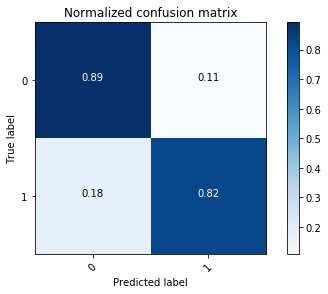

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      7970
           1       0.79      0.82      0.81      3976

   micro avg       0.87      0.87      0.87     11946
   macro avg       0.85      0.86      0.85     11946
weighted avg       0.87      0.87      0.87     11946

2019-04-07 12:05:39


Iteration: 5
[13 12  7 15 10  3 18  5 14  4 17  9  0  2 11  6]
[1, 8, 16, 19]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.9  0.1 ]
 [0.13 0.87]]


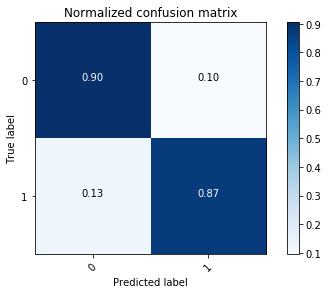

              precision    recall  f1-score   support

           0       0.91      0.90      0.91      6856
           1       0.86      0.87      0.86      4582

   micro avg       0.89      0.89      0.89     11438
   macro avg       0.89      0.89      0.89     11438
weighted avg       0.89      0.89      0.89     11438

2019-04-07 12:06:57


Iteration: 6
[ 2  3 18  1 17 15 11  5  8  4  7  0 10 16  9  6]
[12, 13, 14, 19]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.76 0.24]
 [0.05 0.95]]


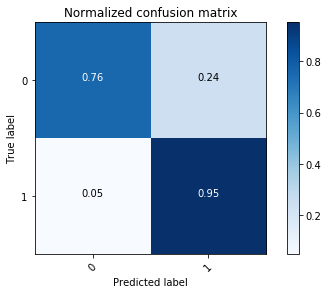

              precision    recall  f1-score   support

           0       0.96      0.76      0.85      5432
           1       0.73      0.95      0.83      3776

   micro avg       0.84      0.84      0.84      9208
   macro avg       0.85      0.86      0.84      9208
weighted avg       0.87      0.84      0.84      9208

2019-04-07 12:08:22


Iteration: 7
[17 10  0 12 13  3 18 16  8  9  1  2 19  4 14  6]
[5, 7, 11, 15]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.83 0.17]
 [0.2  0.8 ]]


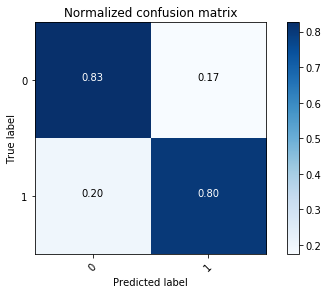

              precision    recall  f1-score   support

           0       0.90      0.83      0.86      8271
           1       0.68      0.80      0.73      3768

   micro avg       0.82      0.82      0.82     12039
   macro avg       0.79      0.81      0.80     12039
weighted avg       0.83      0.82      0.82     12039

2019-04-07 12:09:23


Iteration: 8
[13  5 16  1  7 14  6 11 15 12  3 17  9  4  2 18]
[0, 8, 10, 19]
         0         1         2    3         4         5         6         7   \
0  0.151007  0.053691  0.030201  0.0  0.060403  0.127517  0.036913  0.030201   

         8         9         10        11        12        13        14  \
0  0.020134  0.063758  0.144295  0.033557  0.003356  0.010067  0.050336   

         15  
0  0.184564  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.82 0.18]
 [0.06 0.94]]


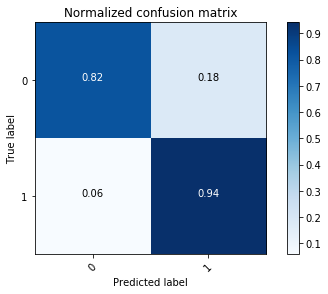

              precision    recall  f1-score   support

           0       0.96      0.82      0.88      6740
           1       0.77      0.94      0.85      4355

   micro avg       0.87      0.87      0.87     11095
   macro avg       0.86      0.88      0.87     11095
weighted avg       0.88      0.87      0.87     11095

2019-04-07 12:10:43


Iteration: 9
[18 12  5 16 19 17  9  1  7  3  4  0  2  8 10 15]
[6, 11, 13, 14]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.81 0.19]
 [0.18 0.82]]


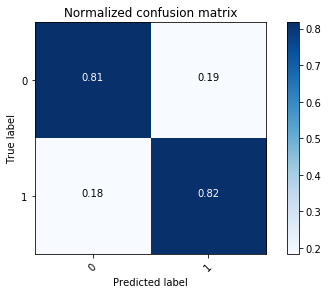

              precision    recall  f1-score   support

           0       0.91      0.81      0.86      7237
           1       0.67      0.82      0.74      3299

   micro avg       0.82      0.82      0.82     10536
   macro avg       0.79      0.82      0.80     10536
weighted avg       0.83      0.82      0.82     10536

2019-04-07 12:12:05

   sensitivity  specificity  accuracy
0     0.881149     0.831489  0.850089
1     0.758499     0.870079  0.832848
2     0.956561     0.770810  0.842460
3     0.941432     0.796199  0.851057
4     0.823441     0.891844  0.869078
5     0.869489     0.904609  0.890540
6     0.951006     0.759389  0.837967
7     0.800955     0.825898  0.818091
8     0.941906     0.820475  0.868139
9     0.817217     0.814979  0.815680
avg sensitivity: 0.8741655041493998
avg specificity: 0.8285770260228883
avg accuracy: 0.8475947482523498


In [30]:
# input param = 1,0.01   # 10,0.01 
## do multiple iterations
sensitivity = []
specificity = []
accuracy = []
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

for i in range(10):
    print('')    
    print("Iteration: " + str(i))
    
    Train, Test = CreateTrainTestID(dfull)
    X_train1, y_train1, X_test, y_test = createXYsets(Train,Test)
    print('')
    
    ### data scaling ###
    scaler = StandardScaler().fit(X_train1)  # StandardScaler();  MinMaxScaler()
    X_train_scaled = scaler.transform(X_train1)    # fit_transform(X_train1)
    X_test_scaled = scaler.transform(X_test)
    
    ## model fitting
    model1_svc = SVC(C= 1, gamma= 0.01, kernel= 'rbf', class_weight='balanced')  # probability=True
    model1_svc.fit(X_train_scaled, y_train1)
    
    
    ## predict on test data - check metrics
    y_pred = model1_svc.predict(X_test_scaled)
    
    
    #####    Compute confusion matrix     ####
    class_names = ['0','1'] #['wake','sleep_stage_1','sleep_stage_2']  # wake, SS1, SS2  ; # '0','1','2'
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    #print(cnf_matrix)
    # Plot normalized confusion matrix : normalisation shows nan for class'0' no signal has class=0 as true label
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()
    
    ## print metrics
    print(classification_report(y_test, y_pred, target_names=class_names))
    #print('accuracy: ' + str(accuracy_score(y_test,y_pred)))
    p = precision_recall_fscore_support(y_test,y_pred)
    #sen = p[1][1]
    #spec = p[1][0]
    #print('sen: ' + str(sen) +' , spec: ' + str(spec))
    sensitivity.append(p[1][1])
    specificity.append(p[1][0])
    accuracy.append(accuracy_score(y_test,y_pred))
    
    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    print('')

sensitivity = pd.DataFrame(sensitivity)
specificity = pd.DataFrame(specificity)
accuracy = pd.DataFrame(accuracy)
metrics = pd.concat([sensitivity, specificity, accuracy], axis=1)
metrics.columns = ['sensitivity', 'specificity', 'accuracy']
print(metrics)
print('avg sensitivity: ' + str(metrics.sensitivity.mean()))
print('avg specificity: ' + str(metrics.specificity.mean()))
print('avg accuracy: ' + str(metrics.accuracy.mean()))    

In [ ]:
#############################################################

## use of probability thresholding ##

## do 5-fold CV
## inside cross-validation, split into train, validation & test indices
## do calc on train & val to get optimal params
#     try :
#     balance with smote / balanced class weight in SVM
#     grid search + CV  -> show plots on train & val error
#     optimise prob thres


In [37]:
## create train & test sets by ID
def CreateTrainValTestID(dfull):
    
    ## select IDs
    ID = dfull['pID'].unique() # create ID list
    #np.random.seed(456)   ## select the IDs for the 2 sets
    
    '''
    msk = np.random.rand(len(ID)) < 0.8
    #print('msk')
    #print(msk)
    trainIDs = pd.DataFrame()
    testIDs = pd.DataFrame()
    trainIDs['pID'] = ID[msk]
    testIDs['pID'] = ID[~msk]
    #print(ID[msk])
    #print(ID[~msk])
    print(trainIDs['pID'].tolist())
    print(testIDs['pID'].tolist())
    Train = dfull.loc[dfull['pID'].isin(ID[msk])] # create the train-test sets
    Test = dfull.loc[dfull['pID'].isin(ID[~msk])] #'''
    
    index_list = list(range(len(ID)))
    #print('index list')
    #print(index_list)
    train1_index = np.random.choice(np.array(index_list), size = round(0.85*(len(index_list))), replace=False)
    test_index = [i for i in index_list if i not in train1_index]
    val_index = np.random.choice(np.array(train1_index), size = round(0.18*(len(train1_index))), replace=False)
    train_index = [i for i in train1_index if i not in val_index]
    Train = dfull.loc[dfull['pID'].isin(ID[train_index])]
    Test = dfull.loc[dfull['pID'].isin(ID[test_index])]
    Val = dfull.loc[dfull['pID'].isin(ID[val_index])]
    print('train')
    print(train_index)
    print('test')
    print(test_index)
    print('val')
    print(val_index)
    return Train, Test, Val

def createXYsets(Train,Test,Val):    
    ## create the sets
    X_train1 = Train.drop(['pID','day','epoch','class_label','class2'], 1).reset_index() #inplace=True, drop=True)  ## create X & y splits
    X_train1 = X_train1.drop(['index'], 1)
    X_test = Test.drop(['pID','day','epoch','class_label','class2'], 1).reset_index() #inplace=True, drop=True)
    X_test = X_test.drop(['index'],1)
    X_val = Val.drop(['pID','day','epoch','class_label','class2'], 1).reset_index()
    X_val = X_val.drop(['index'],1)
    y_train1 = Train['class2'].reset_index() #inplace=True, drop=True)
    y_train1 = y_train1.drop(['index'],1)
    y_test = Test['class2'].reset_index() #inplace=True, drop=True)
    y_test = y_test.drop(['index'],1)
    y_val = Val['class2'].reset_index()
    y_val = y_val.drop(['index'],1)
    #print(X_val.head(1))
    return X_train1, y_train1, X_test, y_test, X_val, y_val

2019-04-07 16:31:55

Iteration: 0
train
[7, 15, 4, 12, 18, 2, 9, 8, 5, 17, 11, 1, 16, 14]
test
[0, 3, 19]
val
[10  6 13]



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


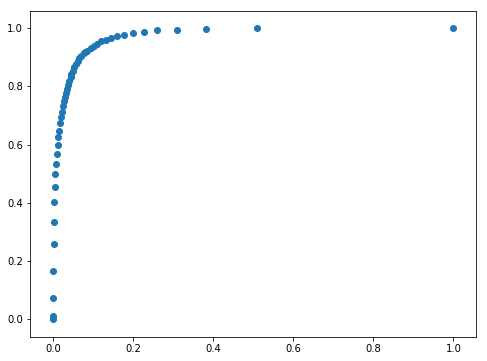

0.9746942891908129
optimal threshold (Youden Index): 0.3
Normalized confusion matrix
[[0.76 0.24]
 [0.05 0.95]]


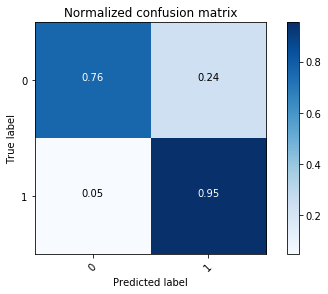

              precision    recall  f1-score   support

           0       0.96      0.76      0.85      4815
           1       0.73      0.95      0.82      3188

   micro avg       0.84      0.84      0.84      8003
   macro avg       0.84      0.86      0.84      8003
weighted avg       0.87      0.84      0.84      8003

2019-04-07 16:37:46


Iteration: 1
train
[11, 13, 12, 16, 7, 14, 2, 9, 6, 18, 4, 10, 15, 1]
test
[0, 8, 17]
val
[19  3  5]



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


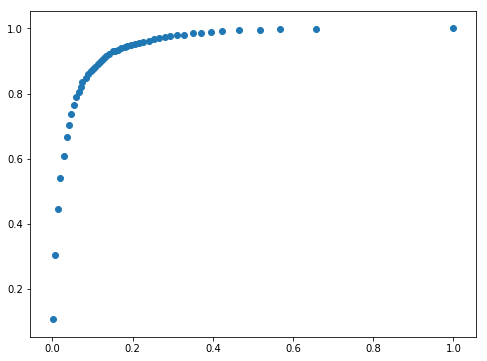

0.9534593078761964
optimal threshold (Youden Index): 0.56
Normalized confusion matrix
[[0.72 0.28]
 [0.08 0.92]]


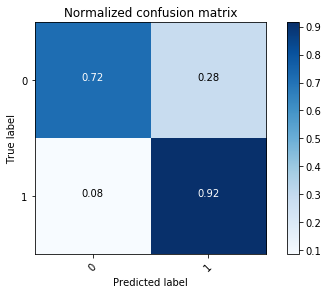

              precision    recall  f1-score   support

           0       0.96      0.72      0.82      6295
           1       0.57      0.92      0.70      2518

   micro avg       0.77      0.77      0.77      8813
   macro avg       0.76      0.82      0.76      8813
weighted avg       0.84      0.77      0.79      8813

2019-04-07 16:42:05


Iteration: 2
train
[6, 12, 17, 3, 19, 0, 10, 5, 15, 16, 1, 9, 2, 18]
test
[4, 7, 13]
val
[ 8 11 14]



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


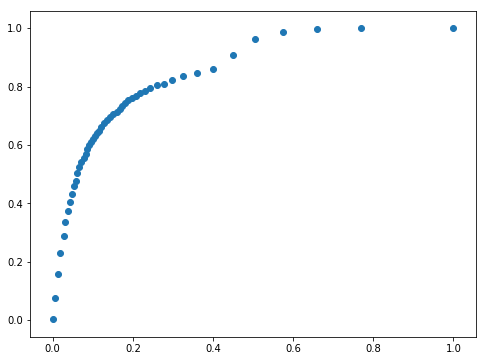

0.8623119399053345
optimal threshold (Youden Index): 0.34
Normalized confusion matrix
[[0.92 0.08]
 [0.16 0.84]]


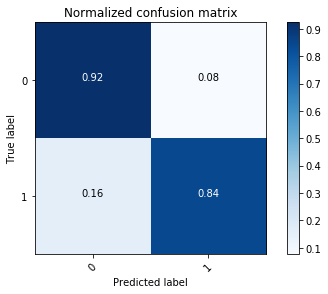

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      4689
           1       0.87      0.84      0.86      2959

   micro avg       0.89      0.89      0.89      7648
   macro avg       0.89      0.88      0.89      7648
weighted avg       0.89      0.89      0.89      7648

2019-04-07 16:46:55


Iteration: 3
train
[16, 5, 8, 9, 7, 14, 15, 18, 10, 6, 1, 17, 11, 13]
test
[0, 2, 4]
val
[12  3 19]



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


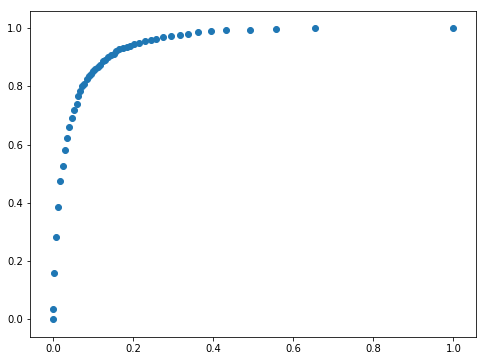

0.948524207183425
optimal threshold (Youden Index): 0.46
Normalized confusion matrix
[[0.91 0.09]
 [0.2  0.8 ]]


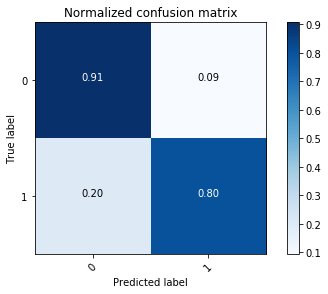

              precision    recall  f1-score   support

           0       0.88      0.91      0.90      5705
           1       0.84      0.80      0.82      3402

   micro avg       0.87      0.87      0.87      9107
   macro avg       0.86      0.85      0.86      9107
weighted avg       0.87      0.87      0.87      9107

2019-04-07 16:51:55


Iteration: 4
train
[14, 15, 5, 1, 11, 0, 3, 6, 19, 4, 12, 7, 2, 8]
test
[9, 10, 13]
val
[17 18 16]



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


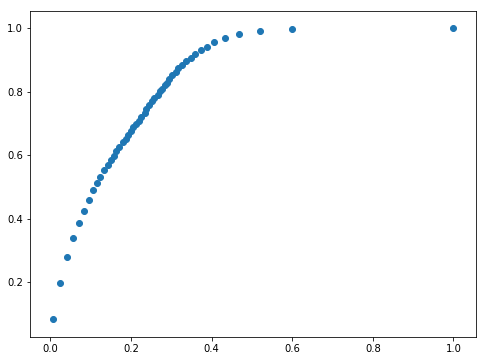

0.8502849504184946
optimal threshold (Youden Index): 0.16
Normalized confusion matrix
[[0.87 0.13]
 [0.06 0.94]]


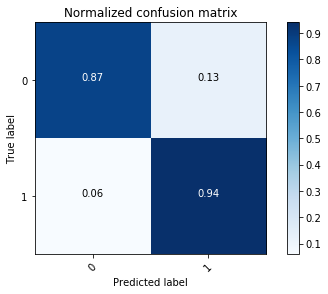

              precision    recall  f1-score   support

           0       0.95      0.87      0.91      4132
           1       0.85      0.94      0.89      3187

   micro avg       0.90      0.90      0.90      7319
   macro avg       0.90      0.91      0.90      7319
weighted avg       0.91      0.90      0.90      7319

2019-04-07 16:57:04

   sensitivity  specificity  accuracy
0     0.953262     0.762409  0.838436
1     0.915409     0.718348  0.774651
2     0.842852     0.923225  0.892129
3     0.799530     0.907099  0.866916
4     0.940697     0.872217  0.902036
avg sensitivity: 0.8903499742852146
avg specificity: 0.8366594962959635
avg accuracy: 0.8548333376138297


In [39]:
### do multiple iterations - get probability threshold using metrics on validation set
sensitivity = []
specificity = []
accuracy = []
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

for j in range(5):
    print('')    
    print("Iteration: " + str(j))
    
    
    ## build datasets
    Train, Test, Val = CreateTrainValTestID(dfull)
    X_train1, y_train1, X_test, y_test, X_val, y_val = createXYsets(Train,Test,Val)
    print('')
    
    
    ### data scaling ###
    scaler = StandardScaler().fit(X_train1)  # StandardScaler();  MinMaxScaler()
    X_train_scaled = scaler.transform(X_train1)    # fit_transform(X_train1)
    X_test_scaled = scaler.transform(X_test)
    X_val_scaled = scaler.transform(X_val)
    
    
    ## model fitting
    model1_svc = SVC(C= 1, gamma= 0.01, kernel= 'rbf', probability=True) # class_weight='balanced')  # probability=True
    model1_svc.fit(X_train_scaled, y_train1.values)
    
    
    ## predict on validation data - check metrics
    y_pred = model1_svc.predict_proba(X_val_scaled)[:,[1]]  ## prob for class 1     #predict(X_test_scaled)
    
    
    ## vary threshold & get metrics on validation set
    cut_off=np.arange(0,1,.02)  # step size=0.02
    metric = []
    #sensitivity=[]
    #specificity=[]
    for m in cut_off:
        array=np.zeros(len(y_pred))
        array_ind=[i for i in range(len(y_pred)) if y_pred[i]>=m]
        array[array_ind]=1
        p=precision_recall_fscore_support(y_val,array) 
        sens = p[1][1]  # sensitivity.append(p[1][1])
        spec = p[1][0]  # specificity.append(p[1][0])
        metric.append([m,sens, spec])
    #sensitivity=pd.DataFrame(np.array(sensitivity))
    #specificity=pd.DataFrame(np.array(specificity))
    metric = pd.DataFrame(metric,columns=['thres', 'sensitivity', 'specificity'])
    metric['FPR'] = 1 - metric['specificity']
    metric['iter'] = j
    
    # plot ROC
    plt.figure(figsize=(8,6))
    plt.scatter(x=1-pd.np.array(metric.iloc[:,[2]]),y=pd.np.array(metric.iloc[:,[1]]))
    plt.show()
    print(auc(1-pd.np.array(metric.iloc[:,[2]]),pd.np.array(metric.iloc[:,[1]])))
    
    # calc Youden index
    optimal_idx = np.argmax(pd.np.array(metric['sensitivity']) - pd.np.array(metric['FPR']))
    optimal_threshold = cut_off[optimal_idx]
    print('optimal threshold (Youden Index): ' + str(optimal_threshold))
    
    
    ## predict on test data
    y_pred_final = model1_svc.predict_proba(X_test_scaled)[:,[1]]
    y_array = np.zeros(len(y_pred_final))
    array_ind = [i for i in range(len(y_pred_final)) if y_pred_final[i]>= optimal_threshold]
    y_array[array_ind] = 1
    
    
    #####    Compute confusion matrix     ####
    class_names = ['0','1'] #['wake','sleep_stage_1','sleep_stage_2']  # wake, SS1, SS2  ; # '0','1','2'
    cnf_matrix = confusion_matrix(y_test, y_array)  # y_pred_final
    np.set_printoptions(precision=2)
    #print(cnf_matrix)
    # Plot normalized confusion matrix : normalisation shows nan for class'0' no signal has class=0 as true label
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()
    
    ## print metrics
    print(classification_report(y_test, y_array, target_names=class_names))  # y_pred_final
    #print('accuracy: ' + str(accuracy_score(y_test,y_pred)))
    p = precision_recall_fscore_support(y_test,y_array)  # y_pred_final
    #sen = p[1][1]
    #spec = p[1][0]
    #print('sen: ' + str(sen) +' , spec: ' + str(spec))
    sensitivity.append(p[1][1])
    specificity.append(p[1][0])
    accuracy.append(accuracy_score(y_test,y_array))
    
    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    print('')

sensitivity = pd.DataFrame(sensitivity)
specificity = pd.DataFrame(specificity)
accuracy = pd.DataFrame(accuracy)
metrics = pd.concat([sensitivity, specificity, accuracy], axis=1)
metrics.columns = ['sensitivity', 'specificity', 'accuracy']
print(metrics)
print('avg sensitivity: ' + str(metrics.sensitivity.mean()))
print('avg specificity: ' + str(metrics.specificity.mean()))
print('avg accuracy: ' + str(metrics.accuracy.mean()))    

2019-04-07 17:15:51

Iteration: 0
train
[11, 6, 18, 8, 0, 10, 1, 16, 3, 19, 12, 4, 7, 17]
test
[2, 5, 14]
val
[15 13  9]



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


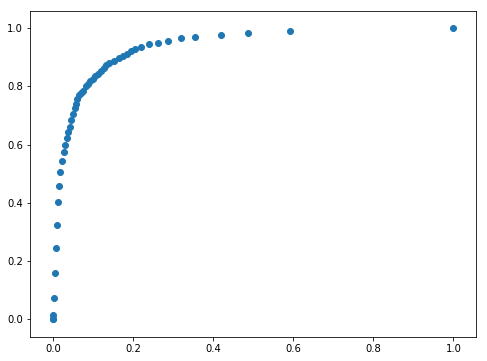

0.939372698796138
optimal threshold (Youden Index): 0.34
Normalized confusion matrix
[[0.83 0.17]
 [0.1  0.9 ]]


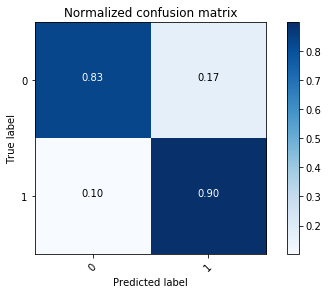

              precision    recall  f1-score   support

           0       0.94      0.83      0.88      6111
           1       0.72      0.90      0.80      3062

   micro avg       0.85      0.85      0.85      9173
   macro avg       0.83      0.86      0.84      9173
weighted avg       0.87      0.85      0.85      9173

2019-04-07 17:22:38


Iteration: 1
train
[0, 16, 7, 13, 6, 17, 19, 4, 1, 3, 18, 5, 10, 11]
test
[2, 8, 9]
val
[15 14 12]



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


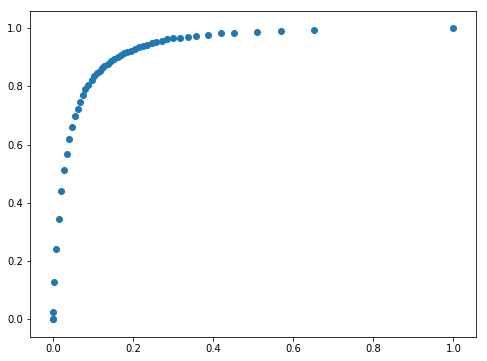

0.937427312331475
optimal threshold (Youden Index): 0.54
Normalized confusion matrix
[[0.95 0.05]
 [0.31 0.69]]


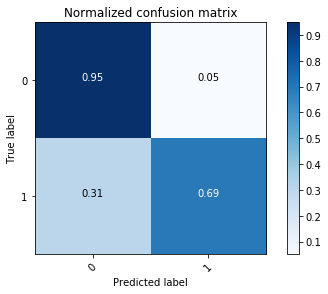

              precision    recall  f1-score   support

           0       0.85      0.95      0.89      5469
           1       0.88      0.69      0.78      3096

   micro avg       0.86      0.86      0.86      8565
   macro avg       0.87      0.82      0.84      8565
weighted avg       0.86      0.86      0.85      8565

2019-04-07 17:28:38


Iteration: 2
train
[4, 10, 5, 1, 6, 11, 12, 17, 18, 7, 15, 16, 9, 3]
test
[0, 2, 13]
val
[19  8 14]



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


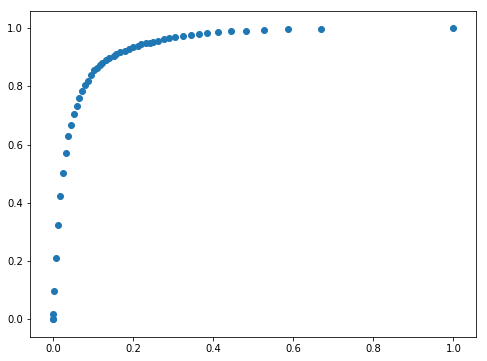

0.9431981811629773
optimal threshold (Youden Index): 0.54
Normalized confusion matrix
[[0.91 0.09]
 [0.22 0.78]]


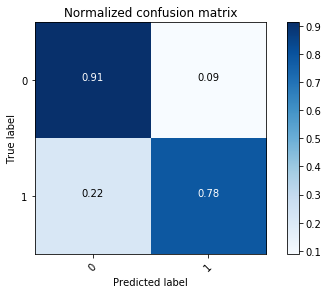

              precision    recall  f1-score   support

           0       0.90      0.91      0.91      5263
           1       0.81      0.78      0.80      2519

   micro avg       0.87      0.87      0.87      7782
   macro avg       0.85      0.85      0.85      7782
weighted avg       0.87      0.87      0.87      7782

2019-04-07 17:36:28


Iteration: 3
train
[17, 6, 12, 13, 9, 4, 5, 14, 18, 19, 15, 2, 16, 7]
test
[3, 8, 11]
val
[ 1 10  0]



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


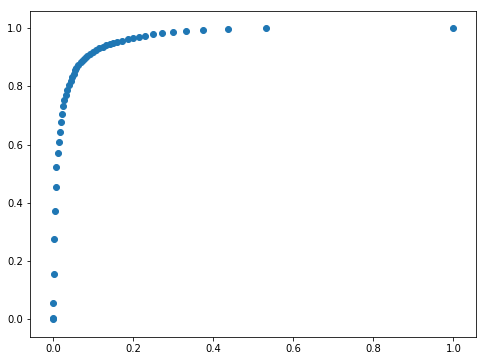

0.9684974923043824
optimal threshold (Youden Index): 0.4
Normalized confusion matrix
[[0.84 0.16]
 [0.24 0.76]]


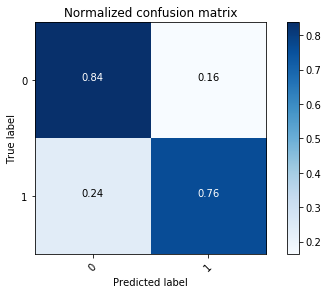

              precision    recall  f1-score   support

           0       0.89      0.84      0.86      6047
           1       0.67      0.76      0.71      2618

   micro avg       0.81      0.81      0.81      8665
   macro avg       0.78      0.80      0.79      8665
weighted avg       0.82      0.81      0.82      8665

2019-04-07 17:42:51


Iteration: 4
train
[13, 17, 19, 14, 0, 11, 4, 1, 7, 8, 12, 18, 10, 2]
test
[3, 5, 6]
val
[16 15  9]



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


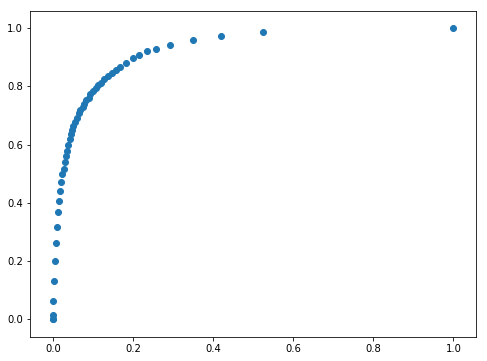

0.9266649983223404
optimal threshold (Youden Index): 0.22
Normalized confusion matrix
[[0.81 0.19]
 [0.04 0.96]]


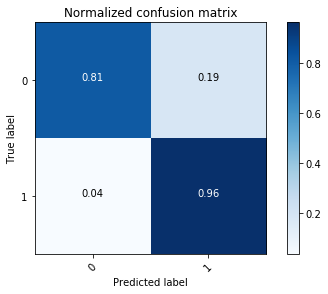

              precision    recall  f1-score   support

           0       0.98      0.81      0.89      6135
           1       0.71      0.96      0.82      2952

   micro avg       0.86      0.86      0.86      9087
   macro avg       0.85      0.89      0.85      9087
weighted avg       0.89      0.86      0.87      9087

2019-04-07 17:49:23

   sensitivity  specificity  accuracy
0     0.898432     0.828179  0.851630
1     0.694767     0.948619  0.856859
2     0.784041     0.912027  0.870599
3     0.761268     0.836944  0.814080
4     0.964431     0.812714  0.862001
avg sensitivity: 0.8205880326282493
avg specificity: 0.867696684446595
avg accuracy: 0.8510336405951542


In [40]:
### do multiple iterations - get probability threshold using metrics on validation set; 
# include class_weight = balanced
sensitivity = []
specificity = []
accuracy = []
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

for j in range(5):
    print('')    
    print("Iteration: " + str(j))
    
    
    ## build datasets
    Train, Test, Val = CreateTrainValTestID(dfull)
    X_train1, y_train1, X_test, y_test, X_val, y_val = createXYsets(Train,Test,Val)
    print('')
    
    
    ### data scaling ###
    scaler = StandardScaler().fit(X_train1)  # StandardScaler();  MinMaxScaler()
    X_train_scaled = scaler.transform(X_train1)    # fit_transform(X_train1)
    X_test_scaled = scaler.transform(X_test)
    X_val_scaled = scaler.transform(X_val)
    
    
    ## model fitting
    model1_svc = SVC(C= 1, gamma= 0.01, kernel= 'rbf', probability=True, class_weight='balanced')  # probability=True
    model1_svc.fit(X_train_scaled, y_train1.values)
    
    
    ## predict on validation data - check metrics
    y_pred = model1_svc.predict_proba(X_val_scaled)[:,[1]]  ## prob for class 1     #predict(X_test_scaled)
    
    
    ## vary threshold & get metrics on validation set
    cut_off=np.arange(0,1,.02)  # step size=0.02
    metric = []
    #sensitivity=[]
    #specificity=[]
    for m in cut_off:
        array=np.zeros(len(y_pred))
        array_ind=[i for i in range(len(y_pred)) if y_pred[i]>=m]
        array[array_ind]=1
        p=precision_recall_fscore_support(y_val,array) 
        sens = p[1][1]  # sensitivity.append(p[1][1])
        spec = p[1][0]  # specificity.append(p[1][0])
        metric.append([m,sens, spec])
    #sensitivity=pd.DataFrame(np.array(sensitivity))
    #specificity=pd.DataFrame(np.array(specificity))
    metric = pd.DataFrame(metric,columns=['thres', 'sensitivity', 'specificity'])
    metric['FPR'] = 1 - metric['specificity']
    metric['iter'] = j
    
    # plot ROC
    plt.figure(figsize=(8,6))
    plt.scatter(x=1-pd.np.array(metric.iloc[:,[2]]),y=pd.np.array(metric.iloc[:,[1]]))
    plt.show()
    print(auc(1-pd.np.array(metric.iloc[:,[2]]),pd.np.array(metric.iloc[:,[1]])))
    
    # calc Youden index
    optimal_idx = np.argmax(pd.np.array(metric['sensitivity']) - pd.np.array(metric['FPR']))
    optimal_threshold = cut_off[optimal_idx]
    print('optimal threshold (Youden Index): ' + str(optimal_threshold))
        
    
    ## predict on test data
    y_pred_final = model1_svc.predict_proba(X_test_scaled)[:,[1]]
    y_array = np.zeros(len(y_pred_final))
    array_ind = [i for i in range(len(y_pred_final)) if y_pred_final[i]>= optimal_threshold]
    y_array[array_ind] = 1
    
    
    #####    Compute confusion matrix     ####
    class_names = ['0','1'] #['wake','sleep_stage_1','sleep_stage_2']  # wake, SS1, SS2  ; # '0','1','2'
    cnf_matrix = confusion_matrix(y_test, y_array)  # y_pred_final
    np.set_printoptions(precision=2)
    #print(cnf_matrix)
    # Plot normalized confusion matrix : normalisation shows nan for class'0' no signal has class=0 as true label
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()
    
    ## print metrics
    print(classification_report(y_test, y_array, target_names=class_names))  # y_pred_final
    #print('accuracy: ' + str(accuracy_score(y_test,y_pred)))
    p = precision_recall_fscore_support(y_test,y_array)  # y_pred_final
    #sen = p[1][1]
    #spec = p[1][0]
    #print('sen: ' + str(sen) +' , spec: ' + str(spec))
    sensitivity.append(p[1][1])
    specificity.append(p[1][0])
    accuracy.append(accuracy_score(y_test,y_array))
    
    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    print('')

sensitivity = pd.DataFrame(sensitivity)
specificity = pd.DataFrame(specificity)
accuracy = pd.DataFrame(accuracy)
metrics = pd.concat([sensitivity, specificity, accuracy], axis=1)
metrics.columns = ['sensitivity', 'specificity', 'accuracy']
print(metrics)
print('avg sensitivity: ' + str(metrics.sensitivity.mean()))
print('avg specificity: ' + str(metrics.specificity.mean()))
print('avg accuracy: ' + str(metrics.accuracy.mean()))    

2019-04-07 18:10:38

Iteration: 0
train
[11, 3, 13, 1, 15, 2, 5, 4, 19, 0, 9, 12, 14, 16]
test
[7, 8, 10]
val
[ 6 18 17]



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


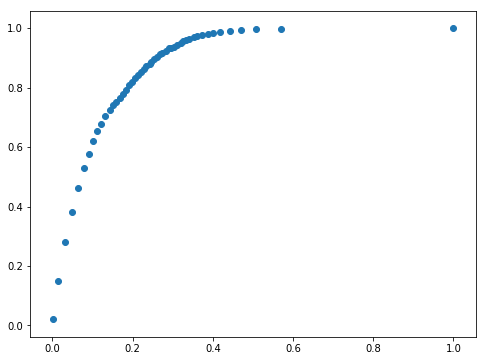

0.8938635719152304
optimal threshold (Youden Index): 0.42
sensitivity: 0.9119669876203577 , specificity: 0.7330214307274374
Normalized confusion matrix
[[0.94 0.06]
 [0.15 0.85]]


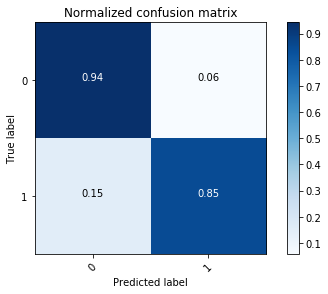

              precision    recall  f1-score   support

           0       0.93      0.94      0.93      6387
           1       0.88      0.85      0.86      3126

   micro avg       0.91      0.91      0.91      9513
   macro avg       0.90      0.90      0.90      9513
weighted avg       0.91      0.91      0.91      9513

2019-04-07 18:15:54


Iteration: 1
train
[5, 18, 7, 9, 2, 6, 0, 1, 15, 12, 8, 11, 16, 3]
test
[13, 14, 19]
val
[17 10  4]



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


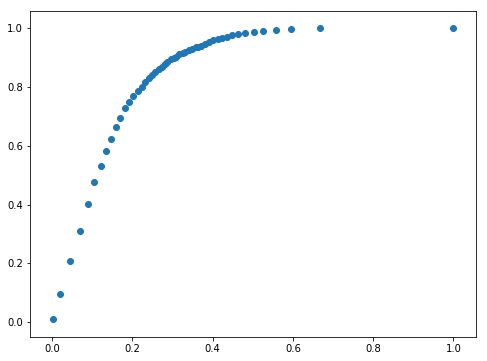

0.8581419036653741
optimal threshold (Youden Index): 0.52
sensitivity: 0.8858436007040483 , specificity: 0.712280701754386
Normalized confusion matrix
[[0.83 0.17]
 [0.07 0.93]]


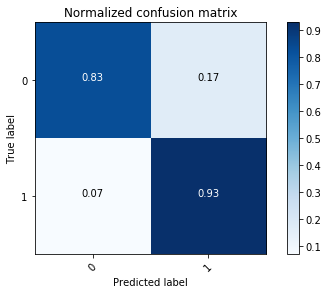

              precision    recall  f1-score   support

           0       0.94      0.83      0.88      3780
           1       0.81      0.93      0.86      2857

   micro avg       0.87      0.87      0.87      6637
   macro avg       0.87      0.88      0.87      6637
weighted avg       0.88      0.87      0.87      6637

2019-04-07 18:21:40


Iteration: 2
train
[16, 1, 9, 3, 17, 5, 18, 15, 19, 10, 14, 12, 4, 8]
test
[0, 7, 13]
val
[11  6  2]



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


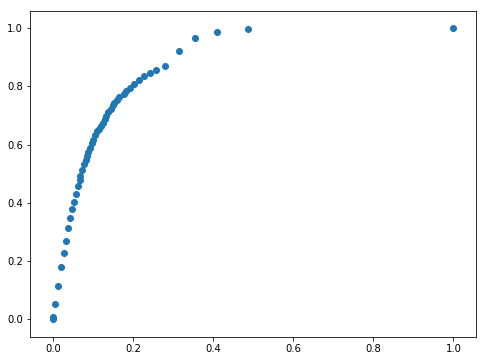

0.8878232564347143
optimal threshold (Youden Index): 0.06
sensitivity: 0.9670294494238156 , specificity: 0.6451007969995312
Normalized confusion matrix
[[0.58 0.42]
 [0.01 0.99]]


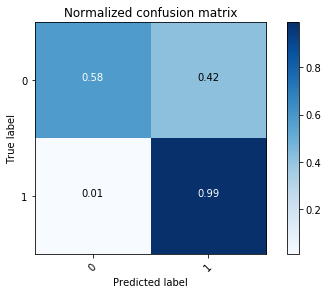

              precision    recall  f1-score   support

           0       0.99      0.58      0.73      5260
           1       0.51      0.99      0.67      2262

   micro avg       0.71      0.71      0.71      7522
   macro avg       0.75      0.79      0.70      7522
weighted avg       0.85      0.71      0.72      7522

2019-04-07 18:27:18


Iteration: 3
train
[0, 10, 9, 13, 15, 16, 8, 17, 11, 4, 5, 6, 18, 14]
test
[1, 3, 19]
val
[12  2  7]



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


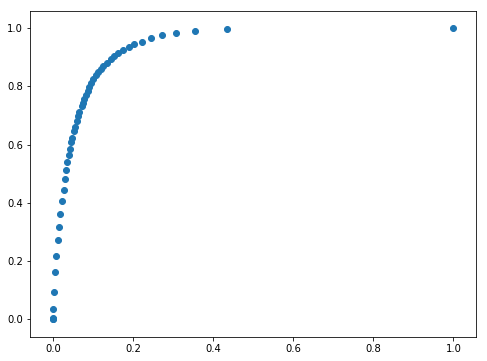

0.9417302724077874
optimal threshold (Youden Index): 0.22
sensitivity: 0.9052056555269923 , specificity: 0.8480667415369806
Normalized confusion matrix
[[0.81 0.19]
 [0.04 0.96]]


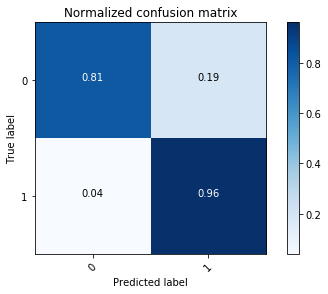

              precision    recall  f1-score   support

           0       0.97      0.81      0.88      5142
           1       0.80      0.96      0.87      3871

   micro avg       0.88      0.88      0.88      9013
   macro avg       0.88      0.89      0.88      9013
weighted avg       0.89      0.88      0.88      9013

2019-04-07 18:33:05


Iteration: 4
train
[15, 8, 4, 17, 19, 11, 13, 10, 18, 7, 3, 16, 6, 14]
test
[1, 2, 12]
val
[9 5 0]



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


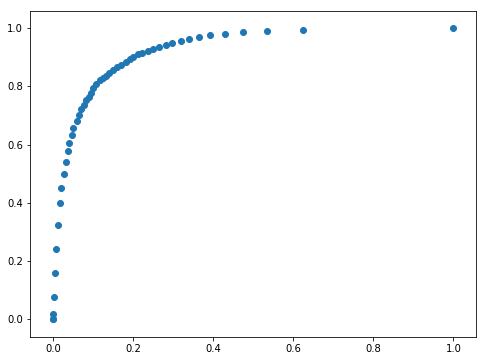

0.9289809498594903
optimal threshold (Youden Index): 0.44
sensitivity: 0.8460743801652892 , specificity: 0.8609715242881072
Normalized confusion matrix
[[0.91 0.09]
 [0.19 0.81]]


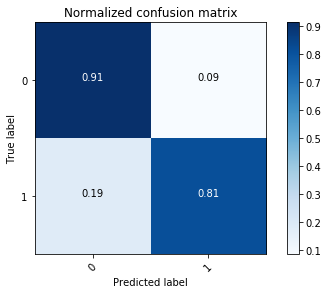

              precision    recall  f1-score   support

           0       0.90      0.91      0.90      6263
           1       0.84      0.81      0.83      3567

   micro avg       0.88      0.88      0.88      9830
   macro avg       0.87      0.86      0.87      9830
weighted avg       0.88      0.88      0.88      9830

2019-04-07 18:38:59

   sensitivity  specificity  accuracy
0     0.848688     0.942696  0.911805
1     0.929996     0.831217  0.873738
2     0.989832     0.583270  0.705530
3     0.960992     0.814275  0.877288
4     0.814690     0.913620  0.877721
avg sensitivity: 0.9088398268410298
avg specificity: 0.8170154534113576
avg accuracy: 0.8492166199981284


In [41]:
### do multiple iterations - get probability threshold using metrics on validation set; 
# include class_weight = balanced
# print the sensitivity & specificity on validation set
sensitivity = []
specificity = []
accuracy = []
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

for j in range(5):
    print('')    
    print("Iteration: " + str(j))
    
    
    ## build datasets
    Train, Test, Val = CreateTrainValTestID(dfull)
    X_train1, y_train1, X_test, y_test, X_val, y_val = createXYsets(Train,Test,Val)
    print('')
    
    
    ### data scaling ###
    scaler = StandardScaler().fit(X_train1)  # StandardScaler();  MinMaxScaler()
    X_train_scaled = scaler.transform(X_train1)    # fit_transform(X_train1)
    X_test_scaled = scaler.transform(X_test)
    X_val_scaled = scaler.transform(X_val)
    
    
    ## model fitting
    model1_svc = SVC(C= 1, gamma= 0.01, kernel= 'rbf', probability=True, class_weight='balanced')  # probability=True
    model1_svc.fit(X_train_scaled, y_train1.values)
    
    
    ## predict on validation data - check metrics
    y_pred = model1_svc.predict_proba(X_val_scaled)[:,[1]]  ## prob for class 1     #predict(X_test_scaled)
    
    
    ## vary threshold & get metrics on validation set
    cut_off=np.arange(0,1,.02)  # step size=0.02
    metric = []
    #sensitivity=[]
    #specificity=[]
    for m in cut_off:
        array=np.zeros(len(y_pred))
        array_ind=[i for i in range(len(y_pred)) if y_pred[i]>=m]
        array[array_ind]=1
        p=precision_recall_fscore_support(y_val,array) 
        sens = p[1][1]  # sensitivity.append(p[1][1])
        spec = p[1][0]  # specificity.append(p[1][0])
        metric.append([m,sens, spec])
    #sensitivity=pd.DataFrame(np.array(sensitivity))
    #specificity=pd.DataFrame(np.array(specificity))
    metric = pd.DataFrame(metric,columns=['thres', 'sensitivity', 'specificity'])
    metric['FPR'] = 1 - metric['specificity']
    metric['iter'] = j
    
    # plot ROC
    plt.figure(figsize=(8,6))
    plt.scatter(x=1-pd.np.array(metric.iloc[:,[2]]),y=pd.np.array(metric.iloc[:,[1]]))
    plt.show()
    print(auc(1-pd.np.array(metric.iloc[:,[2]]),pd.np.array(metric.iloc[:,[1]])))
    
    # calc Youden index
    optimal_idx = np.argmax(pd.np.array(metric['sensitivity']) - pd.np.array(metric['FPR']))
    optimal_threshold = cut_off[optimal_idx]
    print('optimal threshold (Youden Index): ' + str(optimal_threshold))
    print('sensitivity: ' + str(metric.loc[optimal_idx, 'sensitivity']) + ' , specificity: ' + str(metric.loc[optimal_idx, 'specificity']))
    
    
    ## predict on test data
    y_pred_final = model1_svc.predict_proba(X_test_scaled)[:,[1]]
    y_array = np.zeros(len(y_pred_final))
    array_ind = [i for i in range(len(y_pred_final)) if y_pred_final[i]>= optimal_threshold]
    y_array[array_ind] = 1
    
    
    #####    Compute confusion matrix     ####
    class_names = ['0','1'] #['wake','sleep_stage_1','sleep_stage_2']  # wake, SS1, SS2  ; # '0','1','2'
    cnf_matrix = confusion_matrix(y_test, y_array)  # y_pred_final
    np.set_printoptions(precision=2)
    #print(cnf_matrix)
    # Plot normalized confusion matrix : normalisation shows nan for class'0' no signal has class=0 as true label
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()
    
    ## print metrics
    print(classification_report(y_test, y_array, target_names=class_names))  # y_pred_final
    #print('accuracy: ' + str(accuracy_score(y_test,y_pred)))
    p = precision_recall_fscore_support(y_test,y_array)  # y_pred_final
    #sen = p[1][1]
    #spec = p[1][0]
    #print('sen: ' + str(sen) +' , spec: ' + str(spec))
    sensitivity.append(p[1][1])
    specificity.append(p[1][0])
    accuracy.append(accuracy_score(y_test,y_array))
    
    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    print('')

sensitivity = pd.DataFrame(sensitivity)
specificity = pd.DataFrame(specificity)
accuracy = pd.DataFrame(accuracy)
metrics = pd.concat([sensitivity, specificity, accuracy], axis=1)
metrics.columns = ['sensitivity', 'specificity', 'accuracy']
print(metrics)
print('avg sensitivity: ' + str(metrics.sensitivity.mean()))
print('avg specificity: ' + str(metrics.specificity.mean()))
print('avg accuracy: ' + str(metrics.accuracy.mean()))    

In [ ]:
### select youden index by averaging across multiple iterations, then test over another round of iterations
sensitivity = []
specificity = []
accuracy = []
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

for i in range(5):
    print('')    
    print("Iteration: " + str(i))
    
    ## get the same train (merge train + val) & test sets
    
    
    ### data scaling ###
    
    
    ## model fitting
    
    
    ## predict on test data - check metrics
    y_pred = model1_svc.predict_proba(X_test_scaled)[:,[1]]
    
    array=np.zeros(len(y_pred))
    array_ind=[i for i in range(len(y_pred)) if y_pred[i]>= optimal_threshold]
    array[array_ind]=1
    
    #####    Compute confusion matrix     ####
    class_names = ['0','1'] #['wake','sleep_stage_1','sleep_stage_2']  # wake, SS1, SS2  ; # '0','1','2'
    cnf_matrix = confusion_matrix(y_test, array)
    np.set_printoptions(precision=2)
    #print(cnf_matrix)
    # Plot normalized confusion matrix : normalisation shows nan for class'0' no signal has class=0 as true label
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()
    
    print(classification_report(y_test, array, target_names=class_names))
    p=precision_recall_fscore_support(y_test,array)
    sensitivity.append(p[1][1])
    specificity.append(p[1][0])
    accuracy.append(accuracy_score(y_test,y_pred))
    
    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    print('')

sensitivity = pd.DataFrame(sensitivity)
specificity = pd.DataFrame(specificity)
accuracy = pd.DataFrame(accuracy)
metrics = pd.concat([sensitivity, specificity, accuracy], axis=1)
metrics.columns = ['sensitivity', 'specificity', 'accuracy']
print(metrics)
print('avg sensitivity: ' + str(metrics.sensitivity.mean()))
print('avg specificity: ' + str(metrics.specificity.mean()))
print('avg accuracy: ' + str(metrics.accuracy.mean()))    

In [ ]:
### try ensemble of classifiers ###

In [15]:
X.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
58164,0.063545,0.053512,0.026756,0.010033,0.046823,0.130435,0.113712,0.043478,0.016722,0.093645,0.147157,0.086957,0.026756,0.056856,0.056856,0.026756
58165,0.053512,0.050167,0.036789,0.026756,0.056856,0.147157,0.100334,0.053512,0.033445,0.110368,0.073579,0.066890,0.023411,0.050167,0.070234,0.046823
58166,0.100671,0.050336,0.043624,0.010067,0.033557,0.097315,0.097315,0.026846,0.057047,0.077181,0.107383,0.087248,0.013423,0.030201,0.080537,0.087248
58167,0.063545,0.056856,0.023411,0.030100,0.050167,0.107023,0.117057,0.050167,0.023411,0.123746,0.090301,0.070234,0.040134,0.036789,0.076923,0.040134
58168,0.033557,0.040268,0.046980,0.033557,0.060403,0.137584,0.107383,0.030201,0.030201,0.130872,0.093960,0.070470,0.030201,0.026846,0.077181,0.050336


In [11]:
y.tail

<bound method NDFrame.tail of 0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        0
8        0
9        0
10       0
11       0
12       0
13       0
14       0
15       0
16       0
17       0
18       0
19       0
20       0
21       0
22       0
23       0
24       0
25       0
26       0
27       0
28       0
29       0
        ..
58139    1
58140    1
58141    1
58142    1
58143    1
58144    1
58145    1
58146    1
58147    1
58148    1
58149    1
58150    1
58151    1
58152    1
58153    1
58154    1
58155    1
58156    1
58157    1
58158    1
58159    1
58160    1
58161    1
58162    1
58163    1
58164    1
58165    1
58166    1
58167    1
58168    1
Name: class2, Length: 58169, dtype: int64>

In [6]:
#for train_index, test_index in kf.split(pid_tr):
#    print("TRAIN:", pid_tr[train_index], "TEST:", pid_tr[test_index])

### train test split over whole dataset instead of by ID ###
from sklearn.model_selection import StratifiedKFold, KFold, cross_validate, cross_val_score
#pid_tr = dfull['pID'].unique() 
K = 5
kf = KFold(n_splits=K,shuffle=True,random_state=42)
#skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)
#dn = dfull
sensitivity = []
specificity = []
accuracy = []

2019-04-10 11:50:10
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  


C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.84 0.16]
 [0.1  0.9 ]]


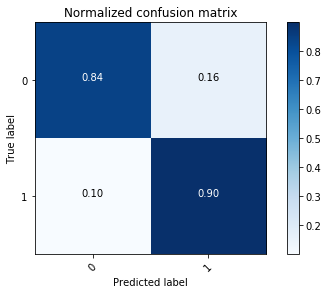

              precision    recall  f1-score   support

           0       0.94      0.84      0.89      7588
           1       0.75      0.90      0.82      4046

   micro avg       0.86      0.86      0.86     11634
   macro avg       0.85      0.87      0.85     11634
weighted avg       0.87      0.86      0.86     11634

2019-04-10 11:51:34

         0        1    2    3         4         5         6    7         8   \
0  0.120805  0.02349  0.0  0.0  0.020134  0.244966  0.083893  0.0  0.003356   

         9         10        11   12   13        14        15  
0  0.077181  0.278523  0.016779  0.0  0.0  0.016779  0.114094  


C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.83 0.17]
 [0.1  0.9 ]]


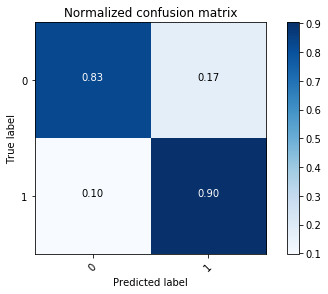

              precision    recall  f1-score   support

           0       0.94      0.83      0.88      7492
           1       0.74      0.90      0.81      4142

   micro avg       0.85      0.85      0.85     11634
   macro avg       0.84      0.86      0.85     11634
weighted avg       0.87      0.85      0.86     11634

2019-04-10 11:52:52

        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  


C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.83 0.17]
 [0.1  0.9 ]]


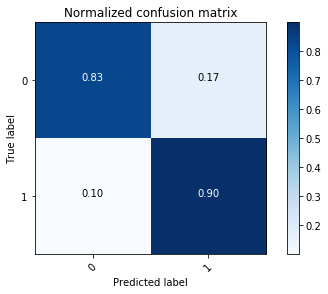

              precision    recall  f1-score   support

           0       0.94      0.83      0.88      7498
           1       0.74      0.90      0.81      4136

   micro avg       0.85      0.85      0.85     11634
   macro avg       0.84      0.86      0.85     11634
weighted avg       0.87      0.85      0.86     11634

2019-04-10 11:54:15

        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  


C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.83 0.17]
 [0.1  0.9 ]]


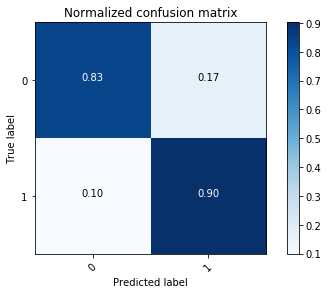

              precision    recall  f1-score   support

           0       0.94      0.83      0.88      7519
           1       0.75      0.90      0.82      4115

   micro avg       0.86      0.86      0.86     11634
   macro avg       0.84      0.87      0.85     11634
weighted avg       0.87      0.86      0.86     11634

2019-04-10 11:55:32

        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  


C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.83 0.17]
 [0.09 0.91]]


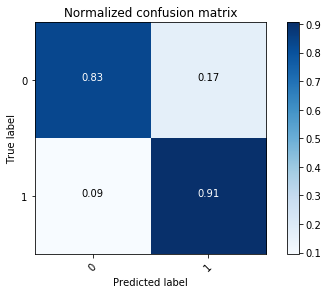

              precision    recall  f1-score   support

           0       0.94      0.83      0.88      7469
           1       0.75      0.91      0.82      4164

   micro avg       0.86      0.86      0.86     11633
   macro avg       0.85      0.87      0.85     11633
weighted avg       0.87      0.86      0.86     11633

2019-04-10 11:56:57

   sensitivity  specificity  accuracy
0     0.899901     0.841065  0.861527
1     0.902704     0.825814  0.853189
2     0.899420     0.827421  0.853017
3     0.902309     0.834419  0.858432
4     0.905620     0.832642  0.858764
avg sensitivity: 0.9019906194748655
avg specificity: 0.8322721484867511
avg accuracy: 0.8569857102262581


In [12]:
### train test split over whole dataset instead of by ID ###

#from sklearn.model_selection import StratifiedKFold  #KFold, cross_validate, cross_val_score
#pid_tr = dfull['pID'].unique() 
#K = 5
#kf = KFold(n_splits=K,shuffle=True,random_state=42)
#skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)
#dn = dfull
#sensitivity = []
#specificity = []
#accuracy = []
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

#X = dfull.drop([ 'day' , 'pID',  'epoch','class_label', 'class2'],1) #.reset_index()
#X = X.drop(['index'], 1)
#print(X.head(1))
#y = pd.DataFrame(dfull['class2']) #.reset_index()
#y = y.drop(['index'], 1)


for train_index, test_index in kf.split(dfull):  #(X,y):
    #print("TRAIN:", list(train_index), "TEST:", list(test_index))
    
    #X_train, X_test = X[train_index], X[test_index]
    #y_train, y_test = y[train_index], y[test_index]
    #df_train = dfull[train_index]
    df_test = dfull.iloc[test_index, :]
    df_train = dfull.iloc[train_index, :]
    
    #print(df_train.tail(1))
    '''df_test = pd.DataFrame()
    df_train = pd.DataFrame()
    for pid in train_index:
        df_tr = dn[(dn['pID']==pid_tr[pid])]
        df_train = pd.concat([df_train,df_tr])
    for pid in test_index:
        df_ts = dn[(dn['pID']==pid_tr[pid])]
        df_test = pd.concat([df_test,df_ts], ignore_index = True)'''
    
    X_train = df_train.drop(['pID', 'day', 'epoch','class_label', 'class2'],1).reset_index()
    X_train = X_train.drop(['index'],1)
        
    y_train = df_train['class2'].reset_index()
    y_train = y_train.drop(['index'],1)
    
    X_test = df_test.drop(['pID', 'day', 'epoch','class_label', 'class2'],1).reset_index()
    X_test = X_test.drop(['index'],1)
    
    y_test = df_test[['class2']].reset_index()
    y_test = y_test.drop(['index'],1)
    print(X_train.head(1))
    
    ### data scaling ###
    scaler = StandardScaler().fit(X_train)  # StandardScaler();  MinMaxScaler()
    X_train_scaled = scaler.transform(X_train)    # fit_transform(X_train1)
    X_test_scaled = scaler.transform(X_test)
    
       
    ## model fitting
    model_svc = SVC(kernel= 'rbf', class_weight='balanced')  # probability=True, C= 10, gamma= 0.01,
    model_svc.fit(X_train_scaled, y_train)
    
    
    ## predict on test data - check metrics
    y_pred = model_svc.predict(X_test_scaled)
    
    
    #####    Compute confusion matrix     ####
    class_names = ['0','1'] #['wake','sleep_stage_1','sleep_stage_2']  # wake, SS1, SS2  ; # '0','1','2'
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    #print(cnf_matrix)
    # Plot normalized confusion matrix : normalisation shows nan for class'0' no signal has class=0 as true label
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()
    
    ## print metrics
    print(classification_report(y_test, y_pred, target_names=class_names))
    #print('accuracy: ' + str(accuracy_score(y_test,y_pred)))
    p = precision_recall_fscore_support(y_test,y_pred)
    #sen = p[1][1]
    #spec = p[1][0]
    #print('sen: ' + str(sen) +' , spec: ' + str(spec))
    sensitivity.append(p[1][1])
    specificity.append(p[1][0])
    accuracy.append(accuracy_score(y_test,y_pred))
    
    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    print('')

sensitivity = pd.DataFrame(sensitivity)
specificity = pd.DataFrame(specificity)
accuracy = pd.DataFrame(accuracy)
metrics = pd.concat([sensitivity, specificity, accuracy], axis=1)
metrics.columns = ['sensitivity', 'specificity', 'accuracy']
print(metrics)
print('avg sensitivity: ' + str(metrics.sensitivity.mean()))
print('avg specificity: ' + str(metrics.specificity.mean()))
print('avg accuracy: ' + str(metrics.accuracy.mean()))    